In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
import random

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 100

## 1.User dataset

In [2]:
user = pd.read_csv("Users.csv",encoding='latin-1')
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [3]:
user = user.rename({'User-ID':'userId'},axis=1)
user.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
user.tail()

,userId,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


In [5]:
df1 = user.copy()

In [6]:
user = user.rename({'User-ID':'userId'},axis=1)
user.head()

,userId,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
user.shape

(278858, 3)

In [8]:
user.describe()

,userId,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


**Minimum value in the age column is 0 and max value is 244 Which is unusual.So we have to remove outliers**

In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


**From the info, we get to know that, there is one null in UserId Column and Many null entries in the age column. So we use isna().sum() function to check how many null values are there.**

In [10]:
user.isna().sum()

userId           0
Location         0
Age         110762
dtype: int64

In [11]:
#Mean = Sum/no. of terms
user_mis_value_percentage = round(user.isna().mean().mul(100),3)
user_mis_value_percentage

userId       0.00
Location     0.00
Age         39.72
dtype: float64

**As the 39.72% of the data is missing(Before treating outliers), We have to impute the missing values without dropping them.**

In [12]:
user.duplicated().sum()

0

Text(0.5, 1.0, 'Outlier in the age column')

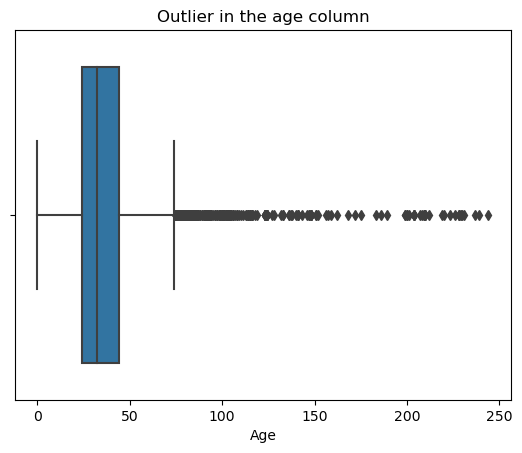

In [13]:
# Let us visualise the outliers in the data
sns.boxplot(x='Age',data=user)
plt.title('Outlier in the age column')

Text(0.5, 1.0, 'Age Distribution Plot')

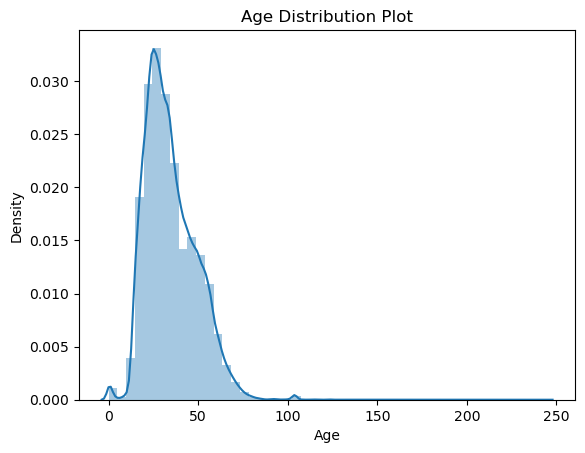

In [14]:
#Lets check the distribution of the data
sns.distplot(user.Age)
plt.title('Age Distribution Plot')

**As the distribution is right skewed and as we have seen in the box plot, there are more outliers on the right side.**

In [15]:
#Considering age between 6-100 is valid range of age for readers,all the other ages are converted to null
user.loc[(user['Age']>100) | (user['Age']<6),'Age'] = np.NAN

Text(0.5, 1.0, 'Age Distribution Plot after replacing invalid age')

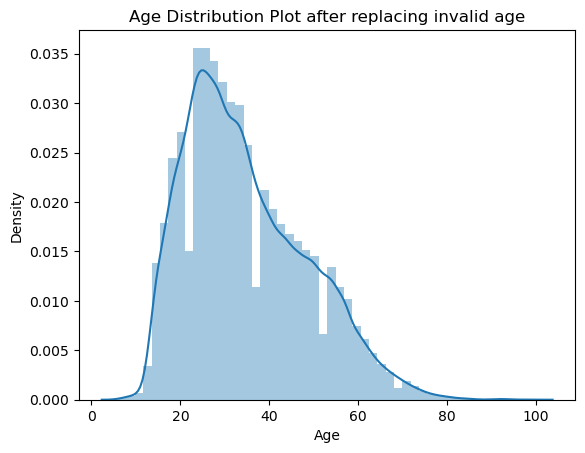

In [16]:
sns.distplot(user.Age)
plt.title('Age Distribution Plot after replacing invalid age')

**We now check the percentage of null values after replacing outliers to null values.**

In [17]:
user_mis_value_percent = round(user.isna().mean().mul(100),3)
user_mis_value_percent

userId       0.000
Location     0.000
Age         40.177
dtype: float64

**Let us try imputing the null values using the Location column. Before that, let us treat the Location column first.**

In [18]:
user.Location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

**As it is difficault to group people using location, We split it into 3 columns.**

In [19]:
user['Country'] = user['Location'].str.rsplit(',').str[-1]
user['State'] = user['Location'].str.rsplit(',').str[1]
user['City'] = user['Location'].str.rsplit(',').str[0]
user.drop('Location',axis=1,inplace=True)
user.head()

,userId,Age,Country,State,City
0,1,NaN,usa,new york,nyc
1,2,18.0,usa,california,stockton
2,3,NaN,russia,yukon territory,moscow
3,4,17.0,portugal,v.n.gaia,porto
4,5,NaN,united kingdom,hants,farnborough


**Here we are grouping the age by Country.**

In [20]:
user.groupby(by = 'Country')['Age'].mean()

Country
                     34.621335
 &#20013;&#22269;    15.000000
 &#32654;&#22269;    31.000000
 *                         NaN
 -                         NaN
                       ...    
 zimbabwe            28.133333
 Ã¤Â¸Â­Ã¥?Â½         21.000000
 Ã¶Ã°Â¹Ãº            26.800000
"                    32.750000
lawrenceville        30.000000
Name: Age, Length: 709, dtype: float64

**Here we get to know that country column contains numeric and other special characters which should be removed**

In [21]:
user['Country'] = user['Country'].str.replace("[^a-zA-Z]"," ") #remove all the special characters and the numbers in the Country column
user['Country'] = user['Country'].str.lower()
user['Country'] = user['Country'].str.strip()
user.Country.nunique()

709

**Still 601 unique countries are there. Now let's group the age by Countries**

In [22]:
user.groupby(by = 'Country')['Age'].mean()

Country
                    34.621335
"                   32.750000
&#20013;&#22269;    15.000000
&#32654;&#22269;    31.000000
*                         NaN
                      ...    
zambia              40.333333
zhengjiang                NaN
zimbabwe            28.133333
ã¤â¸â­ã¥?â½         21.000000
ã¶ã°â¹ãº            26.800000
Name: Age, Length: 709, dtype: float64

**Still some countries are of invalid type. So we have listed all the countries in the dataset.**

In [23]:
user['Country']=user['Country'].astype('str')
c=list(user.Country.unique())
c=set(c)
c=list(c)
c = [x for x in c if x is not None]
c.sort()
print(c)

['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-', '-------', '.', '01776', '02458', '19104', '23232', '30064', '5057chadwick ct.', '85021', '87510', '?ãº?{', '\\"n/a\\""', '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algã©rie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'andorra"', 'angola', 'antarctica', 'antigua & barbuda', 'antigua and barbuda', 'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australia"', 'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan', 'bademn wã¼rtemberg', 'baden-wã¼rttemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belgium"', 'belize', 'bell', 'benin', 'berguedã', 'bermuda', 'bernalillo', 'bfe', '

In [24]:
#remove errors in the country names
x = ['', 'aaa', 'adsgfdr','allen','az','bbbzzzzz','bergued','bfe','bih', 'bkk','c', 'c  te d','c a', 'cadd', 'can', 'cass',
     'chad', 'country','cook','csa','cted', 'de', 'der', 'dfg','kern', 'cape may', 'the gambia','st thomasi',
     'amalurra','diy', 'doodedoo', 'ee uu', 'every where and anywhere', 'evil- empire', 'exactly where i am', 
     'fairyland', 'far away', 'fred','faroe islands','east africa','tdzimi','fredonia   land of the brave and free',
     'heaven', 'h u g','here and there', 'holy see', 'home of the van', 'id','in your heart', 'input error','k c b',
     'ksa', 'kz', 'l','l alg  rie','lake', 'lane', 'lecce', 'lee', 'lj', 'lkjlj','my', 'n a','n a   on the road', 'nan',
     'neverland','nh','nl', 'no more', 'none', 'nowhere', 'nrw','pa', 'per', 'petrolwarnation','pr','st thomasi'
     'princewilliam', 'rice', 'rmi', 'r o c','serbia montenegro''space','strongbadia', 'the', 'the great white north',
     'the world tomorrow', 'thing','travelling','tyrtyrt', 'u', 'unit','fernando de la mora', 'minnehaha', 'afganstand holla',
     'kosovo','serbia   montenegro', 'somalia', 'trinidad   tobago','valtesse','san mateo', 'davidson', 'saint luica',
     'vatican city','nz','east africa','rutherford','somewherein space', 'universe', 'ussurfing','unknown',
     'uyo','we re global','whatcom','wood', 'x', 'xxxxxx', 'z','dauphin','polska','effingham', 'windham','kosovo',
     'cn', 'jackson','ua','nyhamnsl  ge','saint loius', 'hornyonic', 'nyc', 'washtenaw',
    'la chine   ternelle','brunei darussalam', 'cape town','st  helena', 'sultanate of oman', 'aroostook', 'prince william',
    'bademn w  rtemberg', 'gb', 'worcester','van wert','saudia arabia','maricopa','dublin','carter','osceola','myanmar',
    'rapides', 'essex', 'm  rida', 'antigua   barbuda','belgi', 'pinallas', 'bell','serbia and montenegro','liaoning',
    'clinton', 'basilicata', 'bladen', 'sardegna',  'rosario','burkinafasu', 'henry', 'rosello', 'granville', 
     'petrolwar nation','harvatija','prc','sardinia',  'mo  ambique','europa', 'shelby',  'malaysian', 'indiai', 'mordor',
    'fontana', 'kiribati',  'ukrain', 'onondaga nation','queensland', 'solano', 'vorce','la chine eternelle','espanha   galiza',
     'maracopa', 'palestine', 'republic of panama','rsa', 'west yorkshire', 'smith', 'pueblo','pippo','t  rkiye',
    'spotsylvania', 'livingston', 's corea', 'bosnia', 'euskadi','uae', 'yanhill', 'rep san marino', 'johnson', 'maine',
     'buncombe','bucks', 'trinidad tobago', 'houston', 'slovak republik','fortaleza', 'in', 'pistlavakia', 'bavaria',
     's africa','palm beach', 'north carolina', 'russian federation', 'courtenay', 'mauritania', 'hidalgo',
    'xinyu', 'orange co', 'texas', 'baden w  rttemberg', 'a', 'san mateo', 'davidson', 'saint luica','distrito federal',
     'space','evil empire', 'marrion','st  clair', 'rep  san marino', 'victoria','turkei']

    
#replacing spelling similar to usa, canada, uk with their correct spellings, as they are the top 3 occuring countries in users.
for char in x:
    user['Country'] = user['Country'].replace(char, "other")                          #replace errors with other

y = ['clackamas','ysa','wonderful usa', 'ust', 'uusa', 'us', 'usa', 'usa   canada', 'usa  currently living in england',
     'united sates', 'united staes', 'united state', 'united statea', 'united stated', 'united stated of america', 
     'united states', 'united states of america','unite states','u s', 'u s  of a', 'u s  virgin islands', 'u s a',
     'los estados unidos de norte america','hungary and usa','good old u s a', 'good old usa', 'disgruntled states of america', 
     'america', 'american samoa','ohio','butler','fort bend','fulton', 'yakima','collin','baxter','hennipen',
    'baltimore', 'hampden','bernalillo','auckland','pasco',  'morgan', 'slo','dekalb', 'maricopa', 'richmond country',
    'framingham', 'monroe','san franicsco','camden','copenhagen','oakland','ventura','ventura county','california']

for char in y:
    user['Country'] = user['Country'].replace(char, "usa")                                #replcae spelling similar to usa with 'usa'


c = ['canada eh', 'cananda', 'canda','il canada','le canada','st clair',]
u = ['england uk','singapore united kingdom', 'united kindgdom', 'united kindgonm','england','u k','united kingdom','uk',
     'st  vincent and the grenadines','austbritania', 'british virgin islands','london','nederlands','frome','english',
    'thailoand','new london','newzealand','northern ireland']

for char in c:
    user['Country'] = user['Country'].replace(char, "canada")                             #replcae spelling similar to canada with 'canada'

for char in u:
    user['Country'] = user['Country'].replace(char, "united kingdom")                                   #replcae spelling similar to uk with 'uk'
    
m = ['mexico','m       xico','m  xico']

for char in m:
    user['Country'] = user['Country'].replace(char, "mexico")    

i = ['calabria','italia','italien', 'italy', 'itlay','rep san marino','toscana','ferrara','milano', 'europe','lazio','italien']

for char in i:
    user['Country'] = user['Country'].replace(char, "italy")    


p = ['phils','phila','philippines', 'philippinies', 'phillipines', 'phils', 'phippines','the philippines','philippine',
     'phippines']

for char in p:
    user['Country'] = user['Country'].replace(char, "philippines")    

g = ['geermany','germay','ahrensburg']

for char in g:
    user['Country'] = user['Country'].replace(char, "germany")    

ch = ['yunling','liushi','people s republic of china','zhengjiang','cnina','hongkong','chian','china people s republic',
      'p r  china']

for char in ch:
    user['Country'] = user['Country'].replace(char, "china")    

au = ['rep san marino','autralia','australii']

for char in au:
    user['Country'] = user['Country'].replace(char, "australia")    

sw = ['la svizzera','swazilandia','switzerland']

for char in sw:
    user['Country'] = user['Country'].replace(char, "switzerland")    

i1 = ['israel', 'isreal']

for char in i1:
    user['Country'] = user['Country'].replace(char, "israel") 

sr = ['sri lanka  n a','srilanka','sri lanka']

for char in sr:
    user['Country'] = user['Country'].replace(char, "srilanka")

**Here we have checked which are countries are having most value counts(Frequency of the country)**

In [25]:
user.Country.value_counts().reset_index()    

,Country,count
0,usa,139775
1,canada,21664
2,united kingdom,18589
3,germany,17046
4,spain,13147
...,...,...
422,"saint vincent and the grenadines""",1
423,alachua,1
424,"macedonia""",1
425,china ã¶ã°â¹ãº,1


In [26]:
#Lets us check the age for diff countries
user_age_country = user.groupby(['Country', 'Age']).size().reset_index().rename(columns={0:'Num of users'}).sort_values(by = 'Num of users', ascending = False)

In [27]:
user_age_country

,Country,Age,Num of users
4335,usa,34.0,2189
4334,usa,33.0,1982
4336,usa,35.0,1979
4333,usa,32.0,1930
4330,usa,29.0,1930
...,...,...,...
2173,jamaica,43.0,1
2174,jamaica,45.0,1
2175,jamaica,50.0,1
2177,jamaica,56.0,1


**Here we are checking the age distribution of top three frequent countries**

Text(0.5, 1.0, 'Age Distribution of USA users')

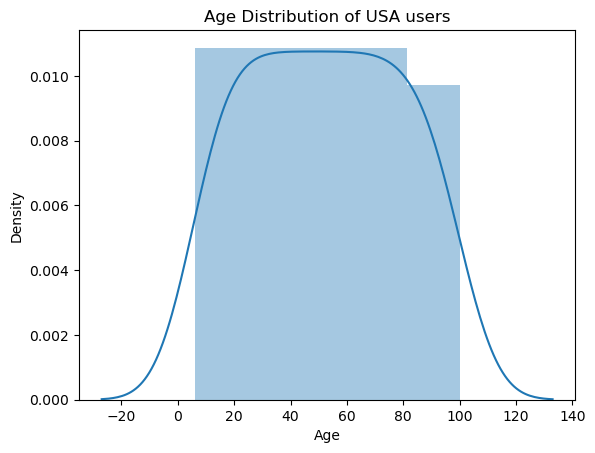

In [28]:
sns.distplot(user_age_country[user_age_country['Country'] == "usa"].Age)
plt.title("Age Distribution of USA users")

**For USA, the age distribution is same for all the ages.That means, the readers of USA are of all the ages between 6 - 100** 

Text(0.5, 1.0, 'Age Distribution of UK users')

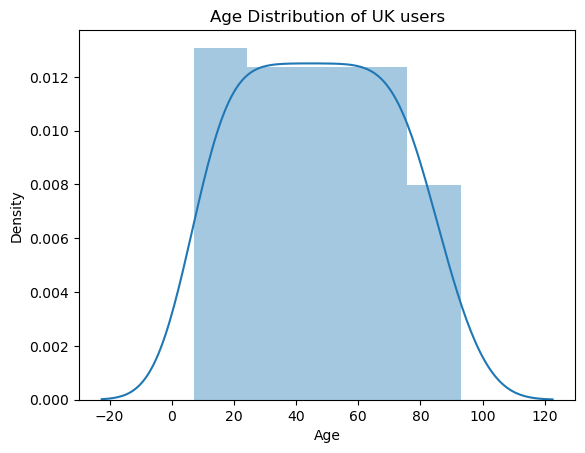

In [29]:
sns.distplot(user_age_country[user_age_country['Country'] == "united kingdom"].Age)
plt.title("Age Distribution of UK users")

**In UK, the readers of age 15 - 25 are more. And the age range is between 15-70**

Text(0.5, 1.0, 'Age Distribution of canada users')

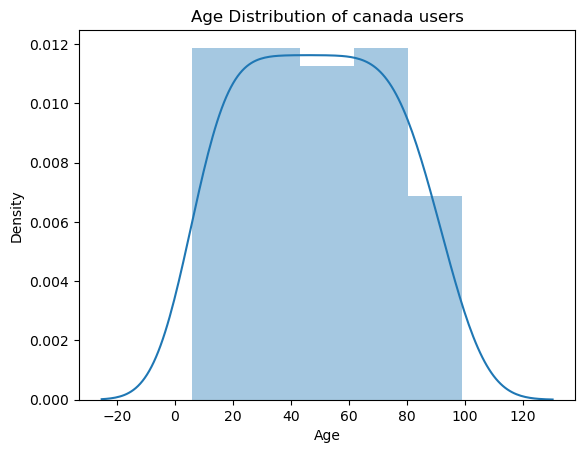

In [30]:
sns.distplot(user_age_country[user_age_country['Country'] == "canada"].Age)
plt.title("Age Distribution of canada users")

**In canada, there are readers from 6 - 100 age group.And the readers of age group 6-80 are more.**

In [31]:
user['Age'] = user['Age'].fillna(round(user.groupby('Country')['Age'].transform('median'), 0))

**Here, we take mean of the age of each country's users to replace the NA in age columns for corresponding country's users**

In [32]:
user_null_new =  user[user.Age.isna()]
user_null_new

,userId,Age,Country,State,City
1997,1998,NaN,"israel""","\n/a\"")",tel-aviv
9098,9099,NaN,19104,philadelphia,4232 spruce st 3f
13635,13636,NaN,u.s. of a.,ok,cheyenne
13781,13782,NaN,afganstand holla !!,alabama,taiblan
13987,13988,NaN,serbia & montenegro,vojvodina,novi sad
...,...,...,...,...,...
271323,271324,NaN,"deutschland""","\n/a\"".",berlin
275281,275282,NaN,rep. san marino,n/a,dogana
276101,276102,NaN,r.o.c.,taiwan,taipei
277747,277748,NaN,"italy""","\n/a\""",rimini


In [33]:
user.isnull().sum() 

userId      0
Age        81
Country     0
State       1
City        0
dtype: int64

**As all the null values in the age are treated and the state and city column is not needed, state and city are dropped**

In [34]:
user = user.drop(['State','City'],axis =1)
user.head()

,userId,Age,Country
0,1,36.0,usa
1,2,18.0,usa
2,3,23.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


##### Top 10 Count of users Country wise

Text(0.5, 1.0, 'Count of users Country wise')

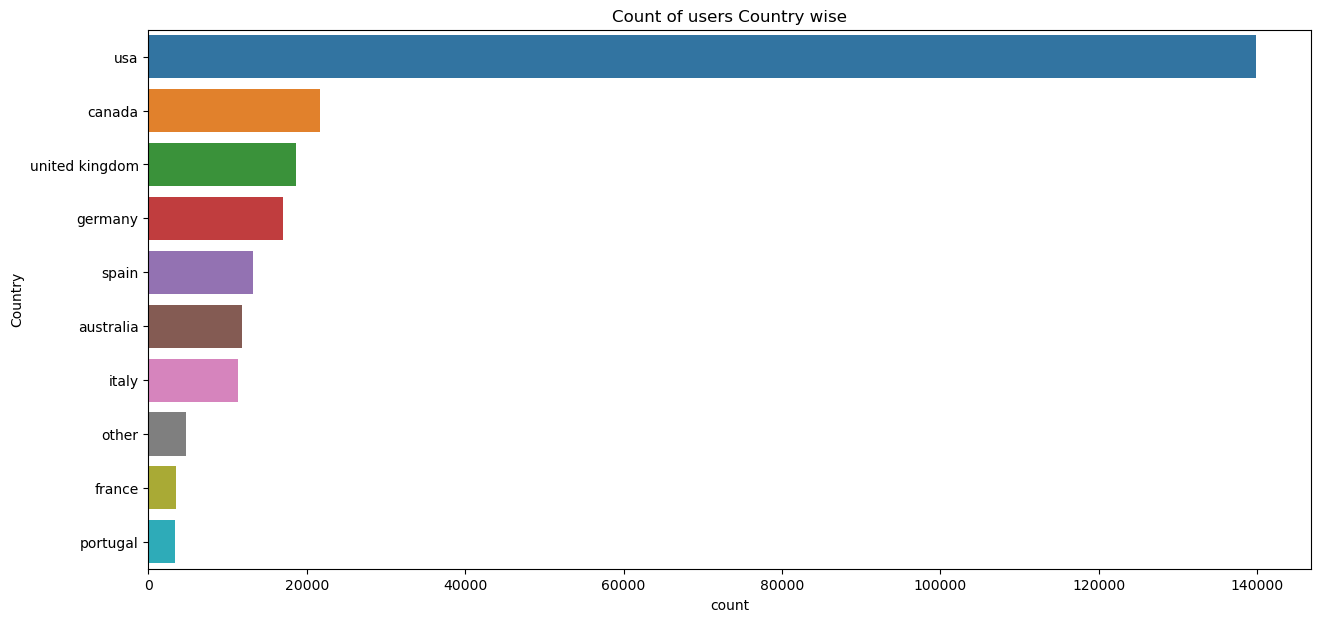

In [35]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'Country',data = user,order=pd.value_counts(user['Country']).iloc[:10].index)
plt.title('Count of users Country wise')

## 2.Book dataset

In [36]:
book = pd.read_csv("Books.csv",encoding='latin-1')
# pd.set_option('display.max_colwidth', None)
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [37]:
book.tail()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440400988.01.LZZZZZZZ.jpg
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0525447644.01.LZZZZZZZ.jpg
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006008667X.01.LZZZZZZZ.jpg
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0192126040.01.LZZZZZZZ.jpg
271359,0767409752,A Guided Tour of Rene Descartes' Meditations on First Philosophy with Complete Translations of t...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767409752.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767409752.01.LZZZZZZZ.jpg


In [38]:
df2 = book.copy()

In [39]:
book = book.rename({'Book-Rating':'rating','Book-Title':'bookTitle',
                    'Book-Author':'bookAuthor','Year-Of-Publication':'publicationYear'},axis=1)
book.head()

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [40]:
book.shape

(271360, 8)

In [41]:
book.describe(include='all')

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/225307649X.01.LZZZZZZZ.jpg
freq,1,27,632,13903,7535,2,2,2


* **Here there are 271360 unique ISBN numbers.**
* **4 book titles are missing. Means, 271356 books are there in which 241360 book titles are unique.We have to check if the books are having different series or it is set of duplicated values.Selected poems is appeared 27 times. We have to find out the reason.**
* **Here they are showing Agatha christie is a top author.It means her books are more.Here 632 books are written by agatha Christie.One book author name is missing. Out of 271359 books, 102023 authors are unique.**
* **There is no null values in year of publication.books published in 2002 are more.**
* **There are 2 null values in Publisher's name. 16806 unique publishers are there.Herlequin published the maximum number of (7535) books.**
* **No null values in image URL S and M columns. There are 3 null values in image URL L column.And image URL also seems to have duplicates. We have to work on that.**

In [42]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ISBN             271360 non-null  object
 1   bookTitle        271360 non-null  object
 2   bookAuthor       271358 non-null  object
 3   publicationYear  271360 non-null  object
 4   Publisher        271358 non-null  object
 5   Image-URL-S      271360 non-null  object
 6   Image-URL-M      271360 non-null  object
 7   Image-URL-L      271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


**The Year of publication column should be integer type. It is showing as object. We have to check that.**

In [43]:
book.isna().sum()

ISBN               0
bookTitle          0
bookAuthor         2
publicationYear    0
Publisher          2
Image-URL-S        0
Image-URL-M        0
Image-URL-L        3
dtype: int64

In [44]:
book.duplicated().sum()

0

In [45]:
#Let us check the missing Image-URL-L
book.loc[book['Image-URL-L'].isna()]

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelb...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?ÃÂ©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";Jam...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


* **We can clearly see here that this is a data entry mistake, columns from book-author have been shifted left, (title and author are clubbed in one row seperated by (\ " ;)**
* **We have to treat these columns**

In [46]:
#Create a seperate df for these 3 rows
edit_df = book.loc[book['Image-URL-L'].isna()]

In [47]:
edit_df['Image-URL-L'] = edit_df['Image-URL-M']
edit_df['Image-URL-M'] = edit_df['Image-URL-S']
edit_df['Image-URL-S'] = edit_df['Publisher']
edit_df['Publisher'] = edit_df['publicationYear']
edit_df['publicationYear'] = edit_df['bookAuthor']

In [48]:
edit_df

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelb...",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?ÃÂ©zio""",2003,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";Jam...",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg


In [49]:
edit_df.loc[edit_df.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
edit_df.loc[edit_df.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [50]:
edit_df.loc[edit_df.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio"
edit_df.loc[edit_df.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [51]:
edit_df.loc[edit_df.ISBN == 789466953,'bookAuthor'] = "James Buckley"
edit_df.loc[edit_df.ISBN == 789466953,'bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [52]:
edit_df

,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃƒ?Ã‚Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";Jam...",2000,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg


In [53]:
#replace book_df rows with edit_df rows
book[book.index == 221678] = edit_df[edit_df.index == 221678]
book[book.index == 220731] = edit_df[edit_df.index == 220731]
book[book.index == 209538] = edit_df[edit_df.index == 209538]

In [54]:
book.dtypes

ISBN               object
bookTitle          object
bookAuthor         object
publicationYear    object
Publisher          object
Image-URL-S        object
Image-URL-M        object
Image-URL-L        object
dtype: object

* **There seems to be an error in Year-of-Publication as it is still showing as object dtype and with no missing values.**

In [55]:
book['publicationYear']=book['publicationYear'].astype('int')

In [56]:
sorted(book['publicationYear'].unique())

[0,
 1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2008,
 2010,
 2011,
 2012,
 2020,
 2021,
 2024,
 2026,
 2030,
 2037,
 2038,
 2050]

In [57]:
book[book['publicationYear']>2022].shape

(13, 8)

In [58]:
book[book['publicationYear']==0].shape

(4618, 8)

* **We have to treat Year-of-Publication = 0 and >2022**

In [59]:
#We'll set the year=0 and > 2022 as null values and try to treat them
book.loc[(book['publicationYear'] > 2022) | (book['publicationYear'] == 0),'publicationYear'] = np.NAN

In [60]:
book.isna().sum()

ISBN                  0
bookTitle             0
bookAuthor            2
publicationYear    4631
Publisher             2
Image-URL-S           0
Image-URL-M           0
Image-URL-L           0
dtype: int64

<Axes: xlabel='publicationYear', ylabel='Density'>

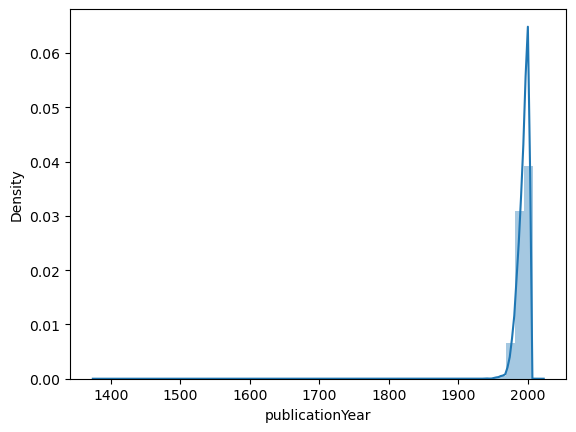

In [61]:
sns.distplot(book['publicationYear'])

In [62]:
print("Mean=", round(book['publicationYear'].mean()))
print("Median=", round(book['publicationYear'].median()))
print("Mode=", book['publicationYear'].mode())

Mean= 1994
Median= 1996
Mode= 0    2002.0
Name: publicationYear, dtype: float64


In [63]:
#we will fill the null values with median of the valid years
book['publicationYear'].fillna(round(book['publicationYear'].median()), inplace=True)

In [64]:
book.isnull().sum()

ISBN               0
bookTitle          0
bookAuthor         2
publicationYear    0
Publisher          2
Image-URL-S        0
Image-URL-M        0
Image-URL-L        0
dtype: int64

In [65]:
book_mis_value_percentage = round(book.isna().mean().mul(100),3)
book_mis_value_percentage

ISBN               0.000
bookTitle          0.000
bookAuthor         0.001
publicationYear    0.000
Publisher          0.001
Image-URL-S        0.000
Image-URL-M        0.000
Image-URL-L        0.000
dtype: float64

* **As the missing value is 0.02% we can drop the rows.**

In [66]:
book = book.dropna()
book.isna().sum()

ISBN               0
bookTitle          0
bookAuthor         0
publicationYear    0
Publisher          0
Image-URL-S        0
Image-URL-M        0
Image-URL-L        0
dtype: int64

In [67]:
book.dtypes

ISBN                object
bookTitle           object
bookAuthor          object
publicationYear    float64
Publisher           object
Image-URL-S         object
Image-URL-M         object
Image-URL-L         object
dtype: object

* **Now all the data types are correct and null datas are imputed**

Text(0.5, 1.0, 'Authors who have written most number of books')

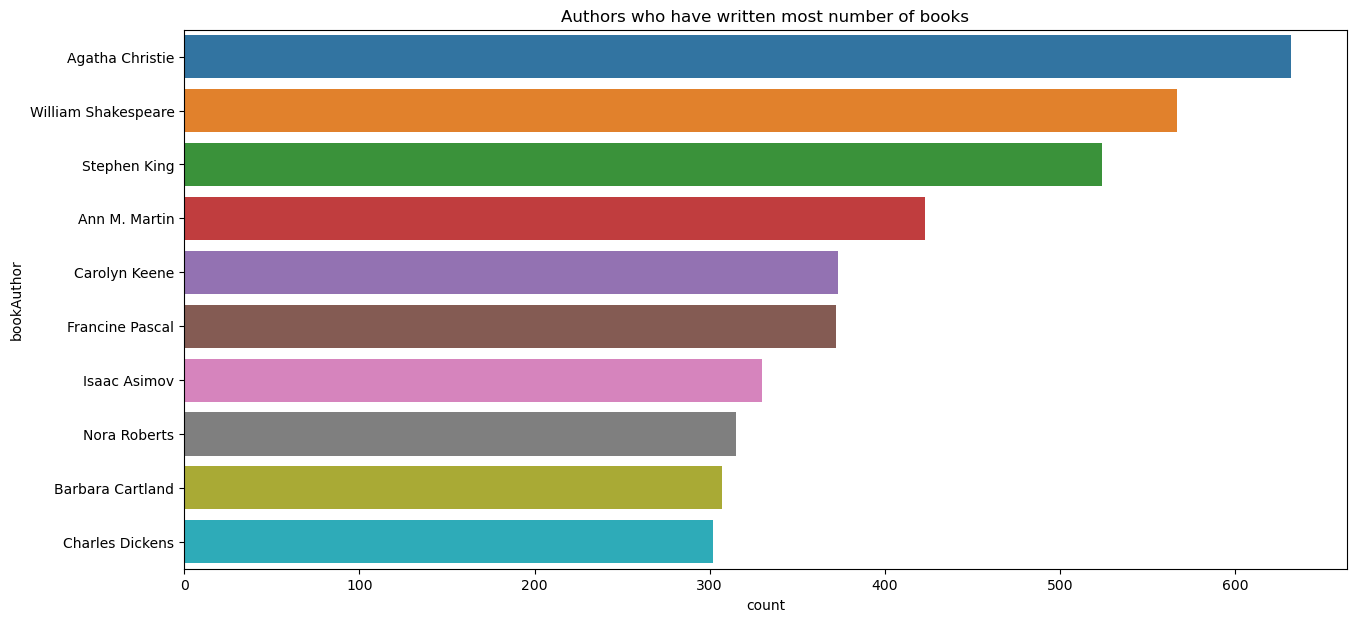

In [68]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'bookAuthor',data = book,order=pd.value_counts(book['bookAuthor']).iloc[:10].index)
plt.title('Authors who have written most number of books')

* **Agatha Christie is the author who has written maximum number of books.**

Text(0.5, 1.0, 'Top years in which most number of books are published')

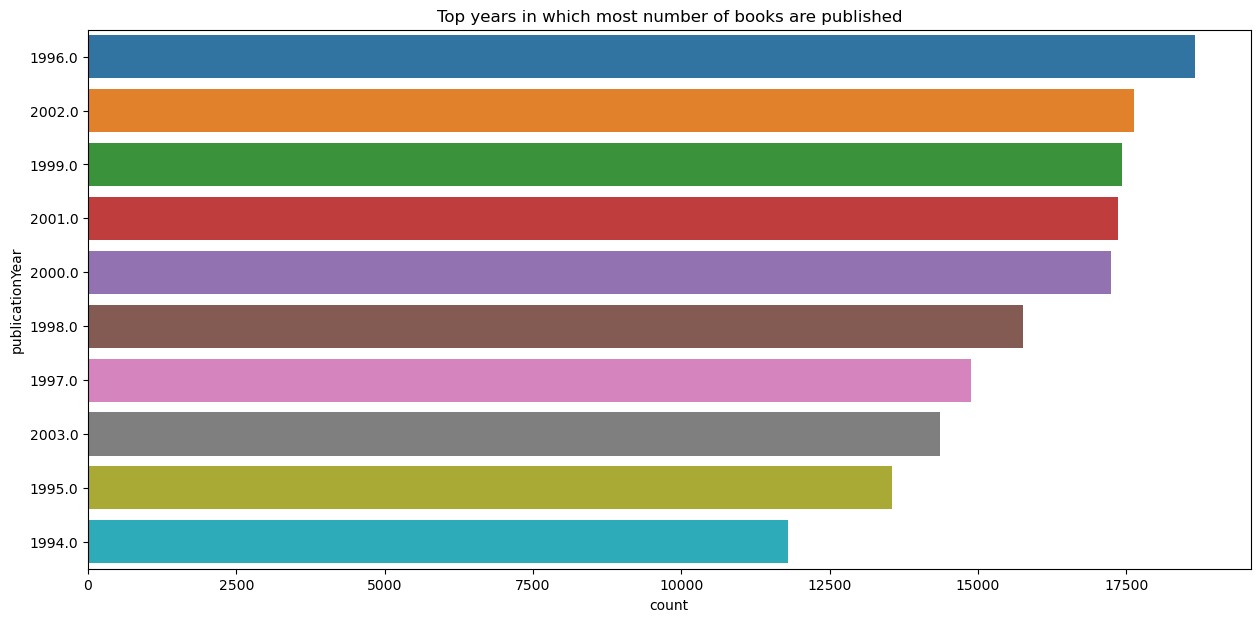

In [69]:
plt.figure(figsize=(15,7))
sns.countplot(y = 'publicationYear',data = book,order=pd.value_counts(book['publicationYear']).iloc[:10].index)
plt.title('Top years in which most number of books are published')

* **1996 is the year when the most number of books were published**

## Rating dataset

In [70]:
rating = pd.read_csv("Ratings.csv",encoding='latin-1')
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [71]:
rating = rating.rename({'User-ID':'userId','Book-Rating':'rating'},axis=1)
rating.head()

,userId,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [72]:
rating.shape

(1149780, 3)

In [73]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   userId  1149780 non-null  int64 
 1   ISBN    1149780 non-null  object
 2   rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


* **From the info, we can clearly say that all the data types are correct and there is no null value**

In [74]:
rating.isna().sum()

userId    0
ISBN      0
rating    0
dtype: int64

In [75]:
rating.duplicated().sum()

0

In [76]:
rating[rating.duplicated()]

,userId,ISBN,rating


In [77]:
round(rating.describe(), 2)

,userId,rating
count,1149780.00,1149780.00
mean,140386.40,2.87
std,80562.28,3.85
min,2.00,0.00
25%,70345.00,0.00
50%,141010.00,0.00
75%,211028.00,7.00
max,278854.00,10.00


* **Here we can see ratings start from 0. But 0 rating means the user didn't read the book or read the book but didn't rate the book**
* **So we calculate the percentage of ratings which are 0.**

In [78]:
rating_duplicated_percentage = (24/1048575)*100
rating_duplicated_percentage

0.002288820542164366

* **So We remove all the duplicate values**
* **Also We see ISBN 0 in the rating dataset which is not in book dataset. We have to drop that too**

In [79]:
rating.drop_duplicates(inplace = True)

In [80]:
rating.shape

(1149780, 3)

In [81]:
rating

,userId,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [82]:
rating_new = rating[rating.ISBN.isin(book.ISBN)]
rating.shape,rating_new.shape

((1149780, 3), (1031132, 3))

* **ISBN which are not in book dataset but in rating dataset are removed. And they are 107454 rows. (They are about 10% of the dataset).**
* **We will not be considering user that are not in the user_df but are in the rating_df dataset as they will not help us to provide complete analysis.**

In [83]:
print("Shape of dataset before dropping",rating_new.shape)
rating_new = rating_new[rating_new['userId'].isin(user['userId'])]
print("shape of dataset after dropping",rating_new.shape)

Shape of dataset before dropping (1031132, 3)
shape of dataset after dropping (1031132, 3)


* **There are no new user in rating df other than user df**

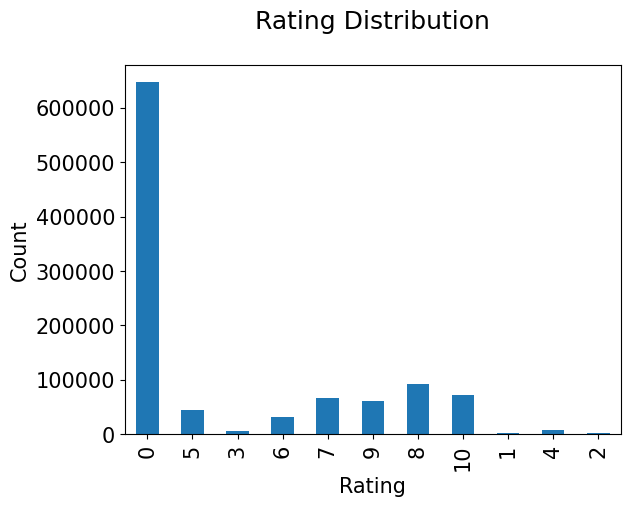

In [84]:
plt.rc("font", size=15)
rating_new['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

* **From the graph, We got to know that, the books that are having 0 rating are more than others. So We check the percentage of 0 rating books and the books which are rated 1-10**

In [85]:
print("% of books that have been rated between 1-10:" , round(((rating_new[rating_new['rating'] != 0].shape[0]/rating_new.shape[0])*100), 2), "%")
print("% of books that have been purchased/read/viewed by user but not rated:" , round(((rating_new[rating_new['rating'] == 0].shape[0]/rating_new.shape[0])*100), 2), "%")

% of books that have been rated between 1-10: 37.22 %
% of books that have been purchased/read/viewed by user but not rated: 62.78 %


**Now we check how is the distribution between 1-10 rated books**

<Axes: title={'center': 'Rating Distribution between 1-10\n'}, xlabel='rating', ylabel='count'>

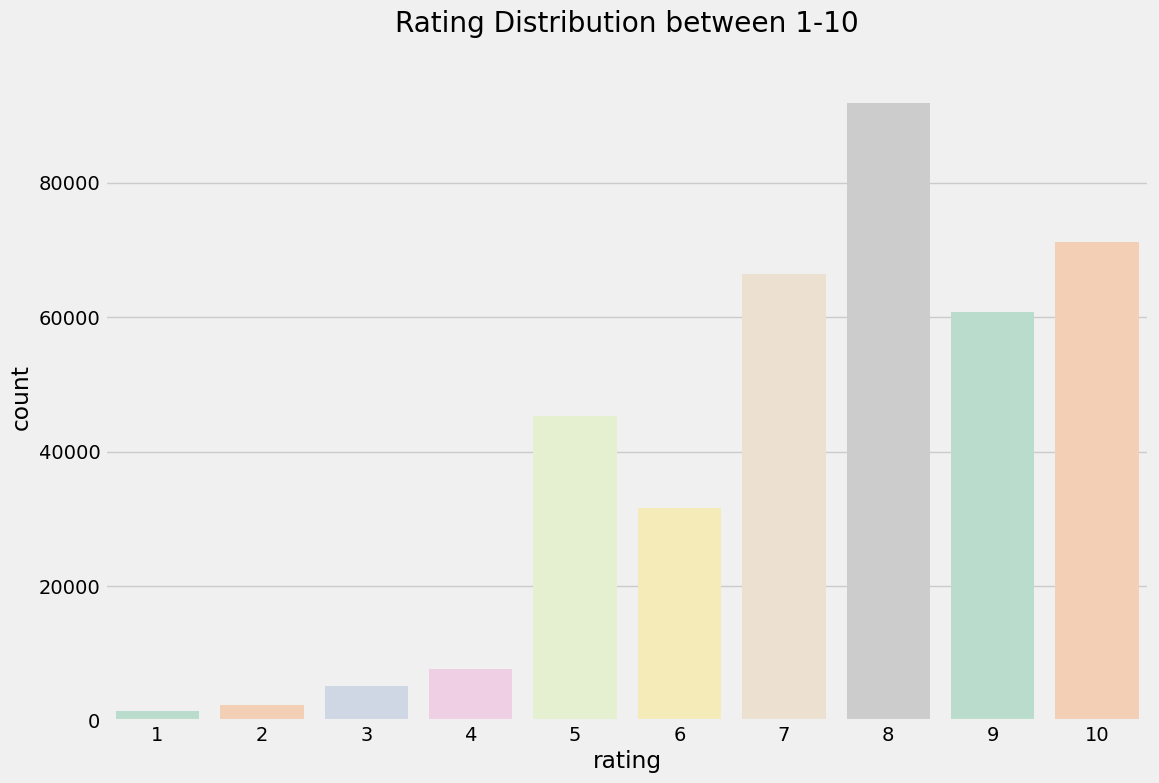

In [86]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.title('Rating Distribution between 1-10\n')
sns.countplot(data = rating_new[rating_new['rating'] != 0] , x='rating', palette='Pastel2')

**Here we can see that 8 is the frequently rated number and 1 is the rarely rated number**

In [87]:
#top 10 books which have been rated by the user max number of times
rating_count = pd.DataFrame(rating_new[rating_new['rating'] != 0].groupby('ISBN')['rating'].count())
rating_count.sort_values('rating', ascending=False).head(10)

,rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320
059035342X,313
0142001740,307
0446672211,295
044023722X,281


In [88]:
most_rated_books = pd.DataFrame([[316666343, 635], [971880107, 526], [385504209,452], [312195516, 354], [60928336, 292], ['059035342X', 285], [142001740,283], [446672211,265], ['044023722X', 259], [452282152,257]], index=np.arange(10), columns = ['ISBN', 'Number of ratings'])
most_rated_books_summary = pd.merge(most_rated_books, book, on='ISBN')
most_rated_books_summary

,ISBN,Number of ratings,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,059035342X,285,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
1,044023722X,259,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books')

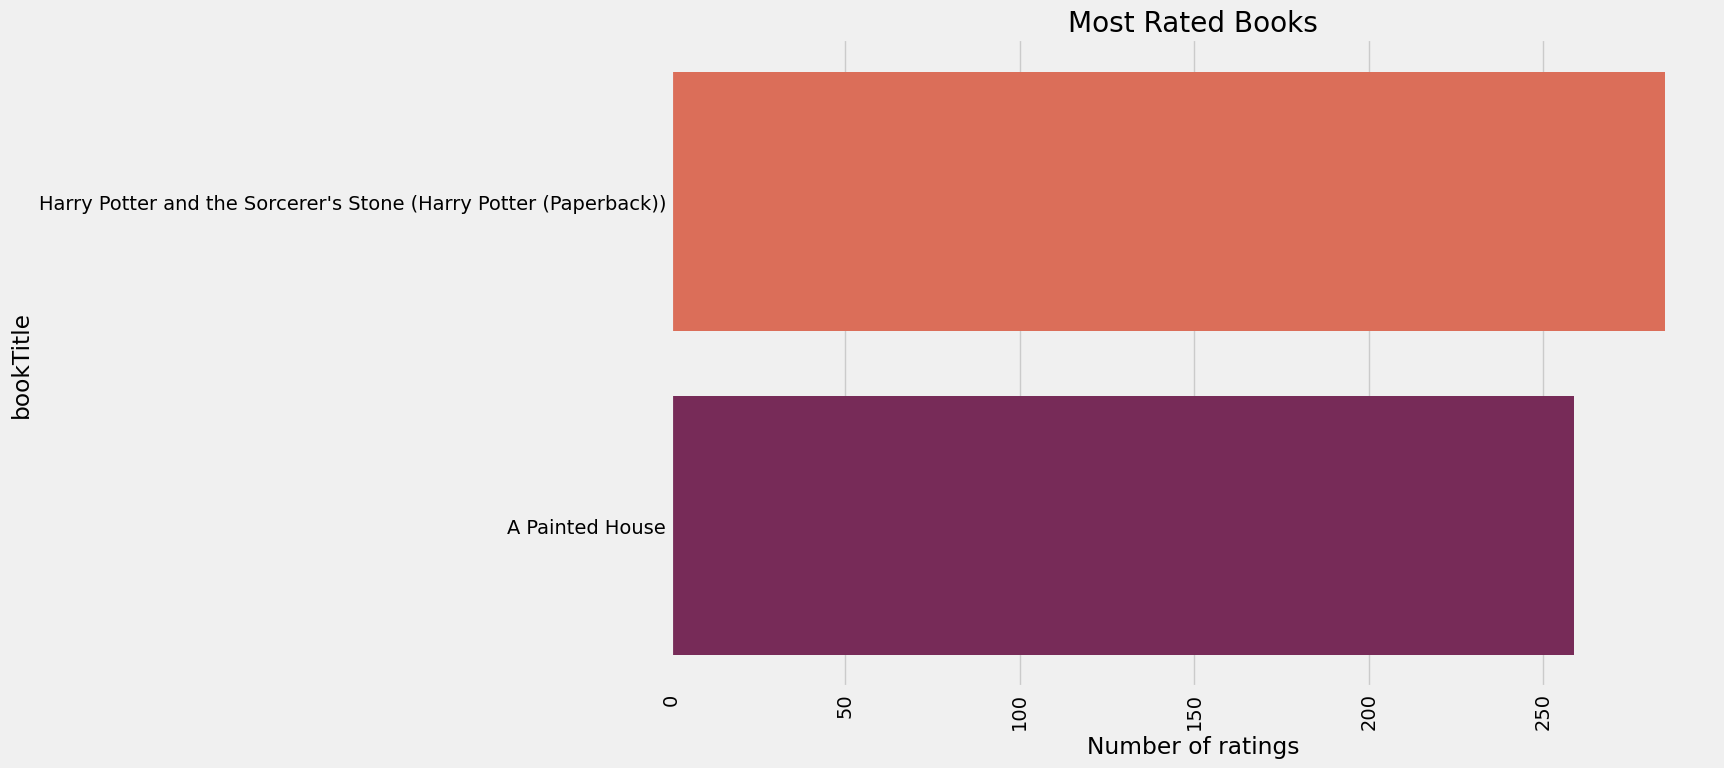

In [89]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_rated_books_summary , y='bookTitle', x = 'Number of ratings' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books")

* **The Lovely Bones: A Novel is the book that is rated by most number of users.**

In [90]:
#top 10 books which have been viewed/read/purchased by the user max number of times
viewed_count = pd.DataFrame(rating_new[rating_new['rating'] == 0].groupby('ISBN')['rating'].count())
viewed_count.sort_values('rating', ascending=False).head(10)

,rating
ISBN,
0971880107,1921
0316666343,588
0060928336,412
0385504209,396
044023722X,366
067976402X,358
0440214041,349
0312195516,340
0804106304,325


In [91]:
most_viewed_books = pd.DataFrame([[971880107, 1738], [316666343,529], [60928336,370], [385504209,361], ['044023722X',336], 
                                  ['067976402X',320], [440214041,314], [312195516,314], [804106304,298], [440211727,293]], index=np.arange(10), columns = ['ISBN', 'Number of views without ratings'])
most_viewed_books_summary = pd.merge(most_viewed_books, book, on='ISBN')
most_viewed_books_summary

,ISBN,Number of views without ratings,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,044023722X,336,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
1,067976402X,320,Snow Falling on Cedars,David Guterson,1995.0,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'The books which are most read/viewed but not rated')

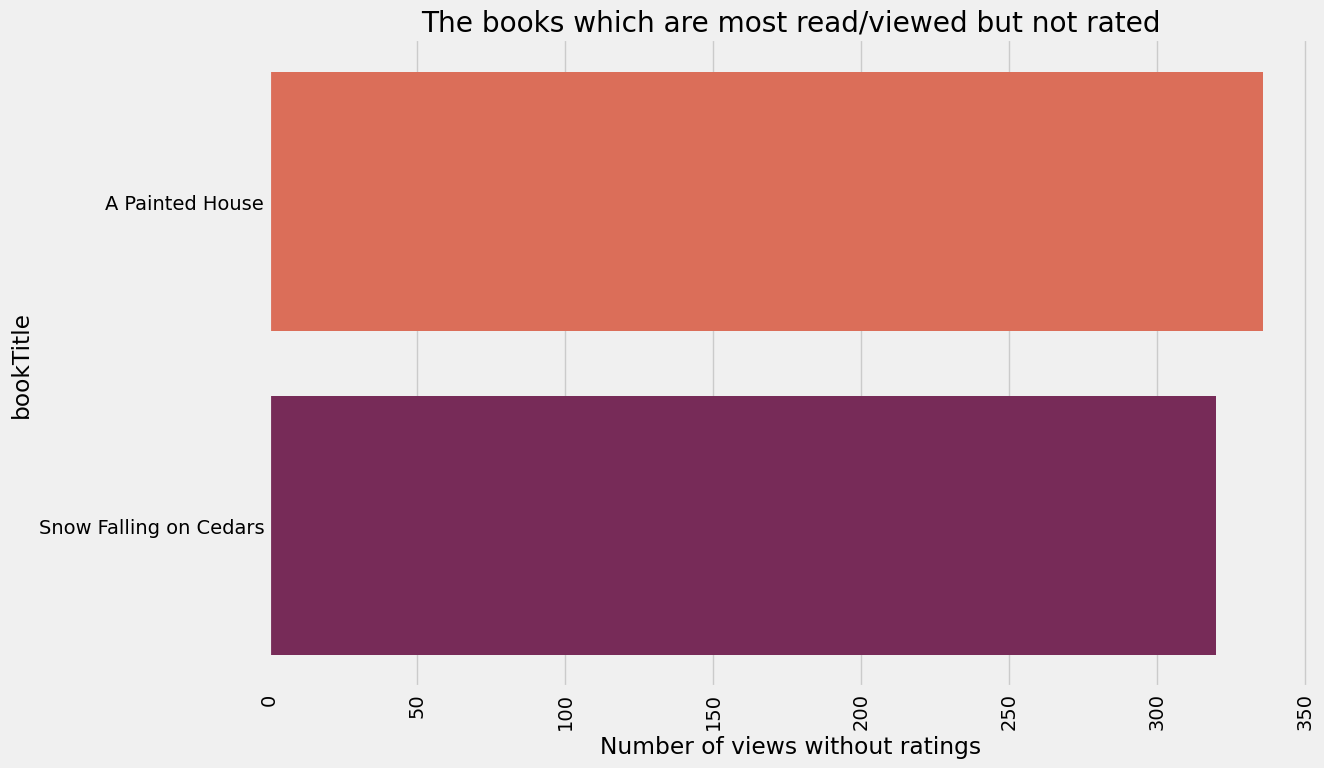

In [92]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_viewed_books_summary , y='bookTitle', x = 'Number of views without ratings' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("The books which are most read/viewed but not rated")

* **Wild animus novels is read/viewed/purchased many times. But not rated**

In [93]:
#User-ID who has purchased/read/viewed most books but not rated
user_count_read = pd.DataFrame(rating_new[rating_new['rating'] == 0].groupby('userId')['rating'].count())
user_count_read.sort_values('rating', ascending=False).head(10)

,rating
userId,
198711,6439
35859,4869
212898,4286
11676,4201
153662,3969
278418,3890
76352,3266
110973,2681
234623,2552


In [94]:
most_user_read = pd.DataFrame([[198711, 6439], [35859,4869], [212898,4286], [11676,4202], [153662,3970], [278418,3891], [76352,3266], [110973,2684], [234623,2553], [230522,2542]], index=np.arange(10), columns = ['userId', 'Number of ratings'])
most_user_read_summary = pd.merge(most_user_read, user, on='userId')
most_user_read_summary

,userId,Number of ratings,Age,Country
0,198711,6439,62.0,usa
1,35859,4869,36.0,usa
2,212898,4286,33.0,canada
3,11676,4202,25.0,n/a
4,153662,3970,44.0,usa
5,278418,3891,36.0,usa
6,76352,3266,58.0,usa
7,110973,2684,43.0,usa
8,234623,2553,36.0,usa
9,230522,2542,52.0,usa


* **Most people who viewed/Purchased/read the book but not rated are from USA and are of the age range 36-62**
* **User ID 198711 read 6439 number of books but not rated them.(?)**


Text(0.5, 1.0, 'Most Users who have read and/or purchased')

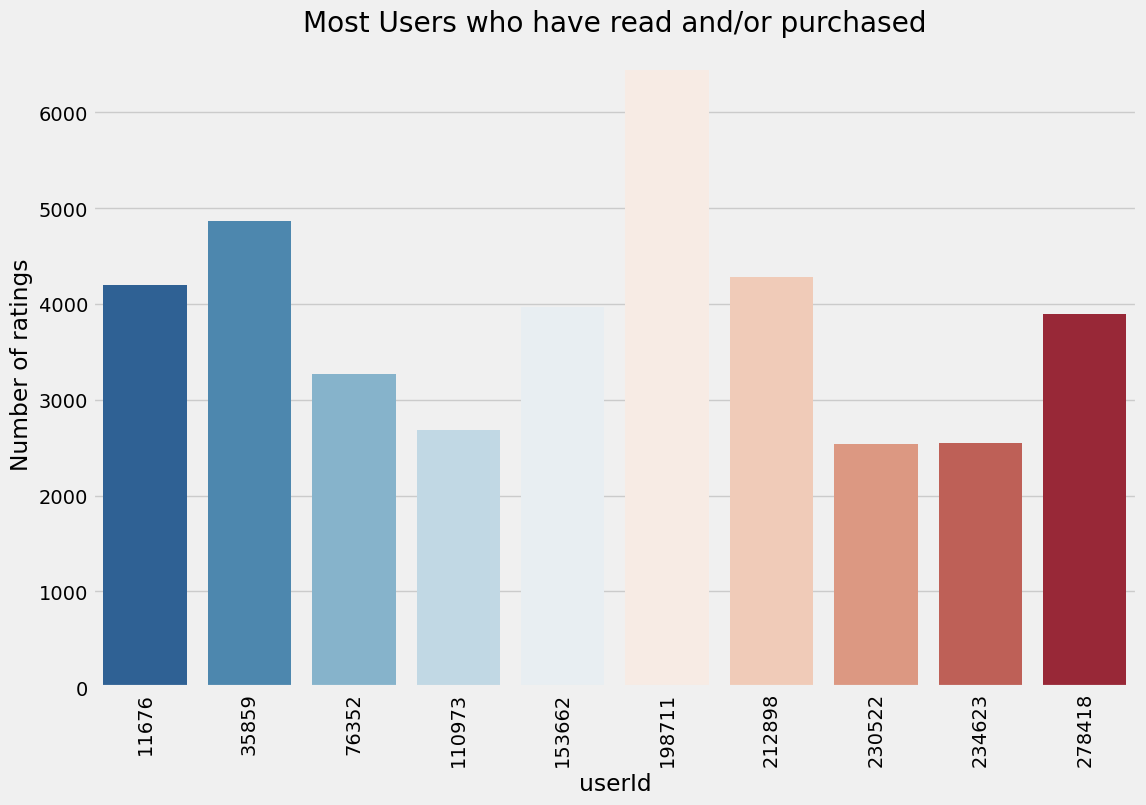

In [95]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_user_read_summary , x='userId', y = 'Number of ratings' ,palette='RdBu_r')
plt.xticks(rotation=90)
plt.title("Most Users who have read and/or purchased")

In [96]:
#User-ID who has rated most books
user_count_rated = pd.DataFrame(rating_new[rating_new['rating'] != 0].groupby('userId')['rating'].count())
user_count_rated.sort_values('rating', ascending=False).head(10)

,rating
userId,
11676,6943
98391,5689
189835,1899
153662,1845
23902,1180
235105,1020
76499,1012
171118,962
16795,959


In [97]:
most_user_rated = pd.DataFrame([[11676,6945], [98391,5691], [189835,1899], [153662,1847], [23902,1181], [235105,1020], [76499,1012], [171118,962], [16795,960], [248718,941]], index=np.arange(10), columns = ['userId', 'Number of ratings'])
most_user_rated_summary = pd.merge(most_user_rated, user, on='userId')
most_user_rated_summary

,userId,Number of ratings,Age,Country
0,11676,6945,25.0,n/a
1,98391,5691,52.0,usa
2,189835,1899,36.0,usa
3,153662,1847,44.0,usa
4,23902,1181,32.0,united kingdom
5,235105,1020,46.0,usa
6,76499,1012,36.0,usa
7,171118,962,47.0,canada
8,16795,960,47.0,usa
9,248718,941,43.0,usa


* **User ID 11676 which has read most number of books and also rated is from some unknown country.Other UserIDs are From USA, canada and Uk.**
* **In USA, The age range of people who have rated along with reading the book are from the age range 36-52.**


Text(0.5, 1.0, 'Most Users who have rated')

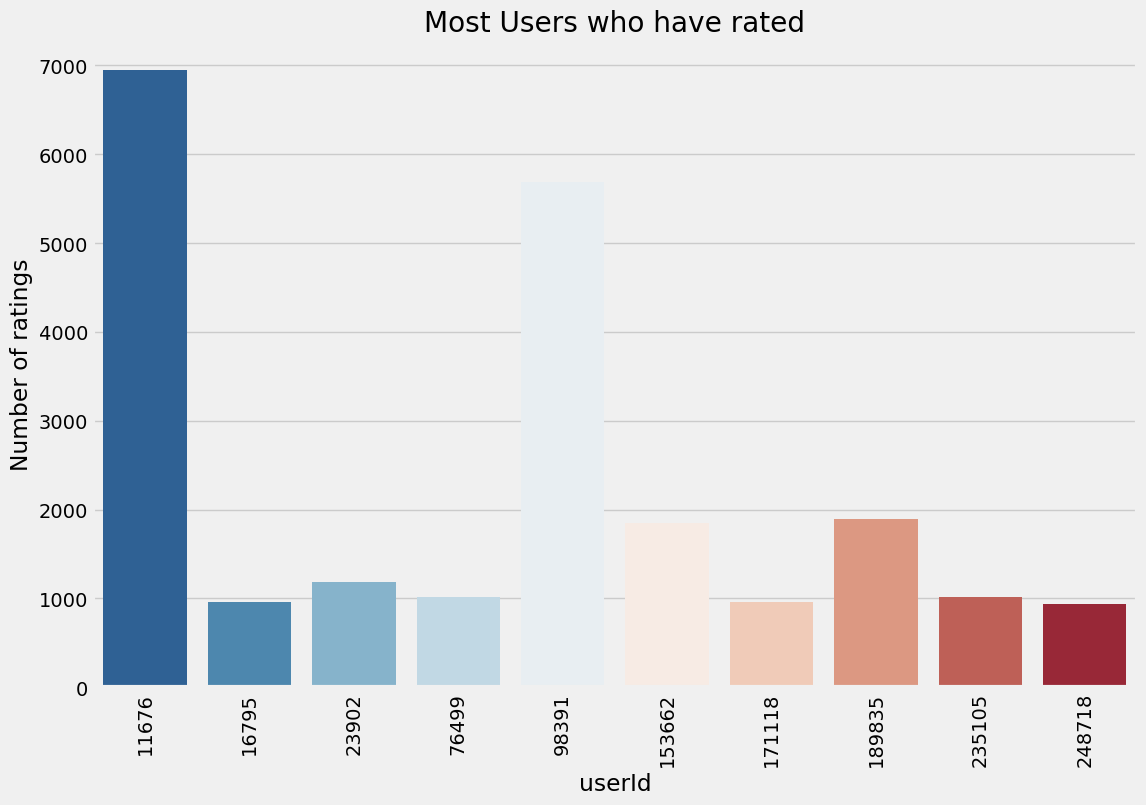

In [98]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=most_user_rated_summary , x='userId', y = 'Number of ratings' ,palette='RdBu_r')
plt.xticks(rotation=90)
plt.title("Most Users who have rated")

In [99]:
user

,userId,Age,Country
0,1,36.0,usa
1,2,18.0,usa
2,3,23.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom
...,...,...,...
278853,278854,36.0,usa
278854,278855,50.0,united kingdom
278855,278856,33.0,canada
278856,278857,36.0,usa


### Merging All Dataset

In [100]:
Final_dataset = user.copy()
Final_dataset = pd.merge(Final_dataset, rating_new, on='userId')
Final_dataset = pd.merge(Final_dataset,book,on='ISBN')

In [101]:
dataset = Final_dataset.copy()
dataset.shape

(1031132, 12)

In [102]:
dataset.Age.fillna(dataset.Age.mean(),inplace=True)  

In [103]:
dataset['Age']=dataset['Age'].astype('int64')

In [104]:
dataset.isnull().sum()

userId             0
Age                0
Country            0
ISBN               0
rating             0
bookTitle          0
bookAuthor         0
publicationYear    0
Publisher          0
Image-URL-S        0
Image-URL-M        0
Image-URL-L        0
dtype: int64

In [105]:
dataset.to_csv('dataset.csv')

In [106]:
pd.read_csv('dataset.csv', index_col=0)

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,18,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,8,33,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,11400,49,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
3,11676,25,NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
4,41385,33,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
1031127,278851,33,usa,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyone Said about How to Play Golf,Randy Voorhees,2000.0,Simon &amp; Schuster,http://images.amazon.com/images/P/0743203763.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743203763.01.LZZZZZZZ.jpg
1031128,278851,33,usa,0767907566,5,All Elevations Unknown: An Adventure in the Heart of Borneo,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0767907566.01.LZZZZZZZ.jpg
1031129,278851,33,usa,0884159221,7,Why stop?: A guide to Texas historical roadside markers,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0884159221.01.LZZZZZZZ.jpg
1031130,278851,33,usa,0912333022,7,The Are You Being Served? Stories: 'Camping In' and Other Fiascoes,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0912333022.01.LZZZZZZZ.jpg


In [107]:
Final_dataset.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,18.0,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,8,33.0,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,11400,49.0,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
3,11676,25.0,n/a,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
4,41385,33.0,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg


In [108]:
round(Final_dataset.isna().mean().mul(100),3)

userId             0.000
Age                0.004
Country            0.000
ISBN               0.000
rating             0.000
bookTitle          0.000
bookAuthor         0.000
publicationYear    0.000
Publisher          0.000
Image-URL-S        0.000
Image-URL-M        0.000
Image-URL-L        0.000
dtype: float64

In [109]:
Final_dataset.shape

(1031132, 12)

In [110]:
Final_dataset['Publication_century']=pd.cut(x=Final_dataset['publicationYear'],bins=[1300,1800,1899,1999,2021], right=True,
                                 labels=[13,18,19,20])

In [111]:
Final_dataset['Age_group']=pd.cut(x=Final_dataset['Age'],bins=[0,12,19,49,100], right=True,
                                 labels=['kid','Teenager','Adult','old'])

In [112]:
Final_dataset.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,2,18.0,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,20,Teenager
1,8,33.0,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,11400,49.0,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,11676,25.0,n/a,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,41385,33.0,canada,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Divide complete data on the basis of implicit and Explicit ratings datasets

In [113]:
## Explicit Ratings Dataset
Final_dataset1 = Final_dataset[Final_dataset['rating'] != 0]
Final_dataset1 = Final_dataset1.reset_index(drop = True)
Final_dataset1.shape

(383838, 14)

In [114]:
## Explicit Ratings Dataset
Final_dataset2 = Final_dataset[Final_dataset['rating'] == 0]
Final_dataset2 = Final_dataset2.reset_index(drop = True)
Final_dataset2.shape

(647294, 14)

## Popularity based recommendation

### Country-wise Filter

In [115]:
Final_dataset1_usa =  Final_dataset1[(Final_dataset1['Country'] == 'usa')]
Final_dataset1_usa.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
9,2954,71.0,usa,0060973129,8,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
11,35704,53.0,usa,0374157065,6,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
12,110912,36.0,usa,0374157065,10,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
13,157969,30.0,usa,0374157065,8,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
14,192665,47.0,usa,0374157065,8,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult


In [116]:
Final_dataset1_uk =  Final_dataset1[(Final_dataset1['Country'] == 'united kingdom')]
Final_dataset1_uk.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
223,12863,29.0,united kingdom,0452264464,9,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,Adult
228,27624,54.0,united kingdom,0452264464,8,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,old
263,132930,29.0,united kingdom,0452264464,9,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,http://images.amazon.com/images/P/0452264464.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452264464.01.LZZZZZZZ.jpg,19,Adult
328,4131,51.0,united kingdom,0971880107,1,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,old
333,7105,32.0,united kingdom,0971880107,6,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,Adult


In [117]:
Final_dataset1_canada =  Final_dataset1[(Final_dataset1['Country'] == 'canada')]
Final_dataset1_canada.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
5,200273,33.0,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
6,210926,33.0,canada,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Age-wise filter

In [118]:
Final_dataset1_kid =  Final_dataset1[(Final_dataset1['Age_group'] == 'kid')]
Final_dataset1_kid.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
715,197792,7.0,australia,0971880107,3,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg,20,kid
1599,208510,12.0,usa,0449005615,10,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002.0,Ballantine Books,http://images.amazon.com/images/P/0449005615.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0449005615.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0449005615.01.LZZZZZZZ.jpg,20,kid
1909,269566,9.0,usa,0440223571,7,This Year It Will Be Different: And Other Stories,Maeve Binchy,1997.0,Dell,http://images.amazon.com/images/P/0440223571.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440223571.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440223571.01.LZZZZZZZ.jpg,19,kid
2378,269566,9.0,usa,0804106304,8,The Joy Luck Club,Amy Tan,1994.0,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.LZZZZZZZ.jpg,19,kid
5814,269566,9.0,usa,0316601950,7,The Pilot's Wife : A Novel,Anita Shreve,1999.0,Back Bay Books,http://images.amazon.com/images/P/0316601950.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.LZZZZZZZ.jpg,19,kid


In [119]:
Final_dataset1_adult =  Final_dataset1[(Final_dataset1['Age_group'] == 'Adult')]
Final_dataset1_adult.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
1,11676,25.0,n/a,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,116866,32.0,other,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


In [120]:
Final_dataset1_old =  Final_dataset1[(Final_dataset1['Age_group'] == 'old')]
Final_dataset1_old.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
7,219008,60.0,canada,0002005018,7,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,old
9,2954,71.0,usa,0060973129,8,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
11,35704,53.0,usa,0374157065,6,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
29,230522,52.0,usa,0399135782,7,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg,19,old
49,7352,53.0,usa,0440234743,8,The Testament,John Grisham,1999.0,Dell,http://images.amazon.com/images/P/0440234743.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440234743.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440234743.01.LZZZZZZZ.jpg,19,old


### Century-wise filter

In [121]:
Final_dataset1_19 =  Final_dataset1[(Final_dataset1['Publication_century'] == 19)]
Final_dataset1_19.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
9,2954,71.0,usa,0060973129,8,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,old
10,152827,40.0,canada,0060973129,7,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg,19,Adult
11,35704,53.0,usa,0374157065,6,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,old
12,110912,36.0,usa,0374157065,10,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult
13,157969,30.0,usa,0374157065,8,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg,19,Adult


In [122]:
Final_dataset1_20 =  Final_dataset1[(Final_dataset1['Publication_century'] == 20)]
Final_dataset1_20.head()

,userId,Age,Country,ISBN,rating,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Publication_century,Age_group
0,8,33.0,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
1,11676,25.0,n/a,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
2,67544,30.0,canada,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
3,116866,32.0,other,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult
4,123629,33.0,canada,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,20,Adult


### Popular books for whole collection

In [123]:
ratings_count = pd.DataFrame(Final_dataset1.groupby(['ISBN'])['rating'].sum())
top_10 = ratings_count.sort_values('rating',ascending=False).head(10)
top_10 = top_10.merge(book,left_index = True,right_on = 'ISBN')
top_10

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2551,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in whole collection')

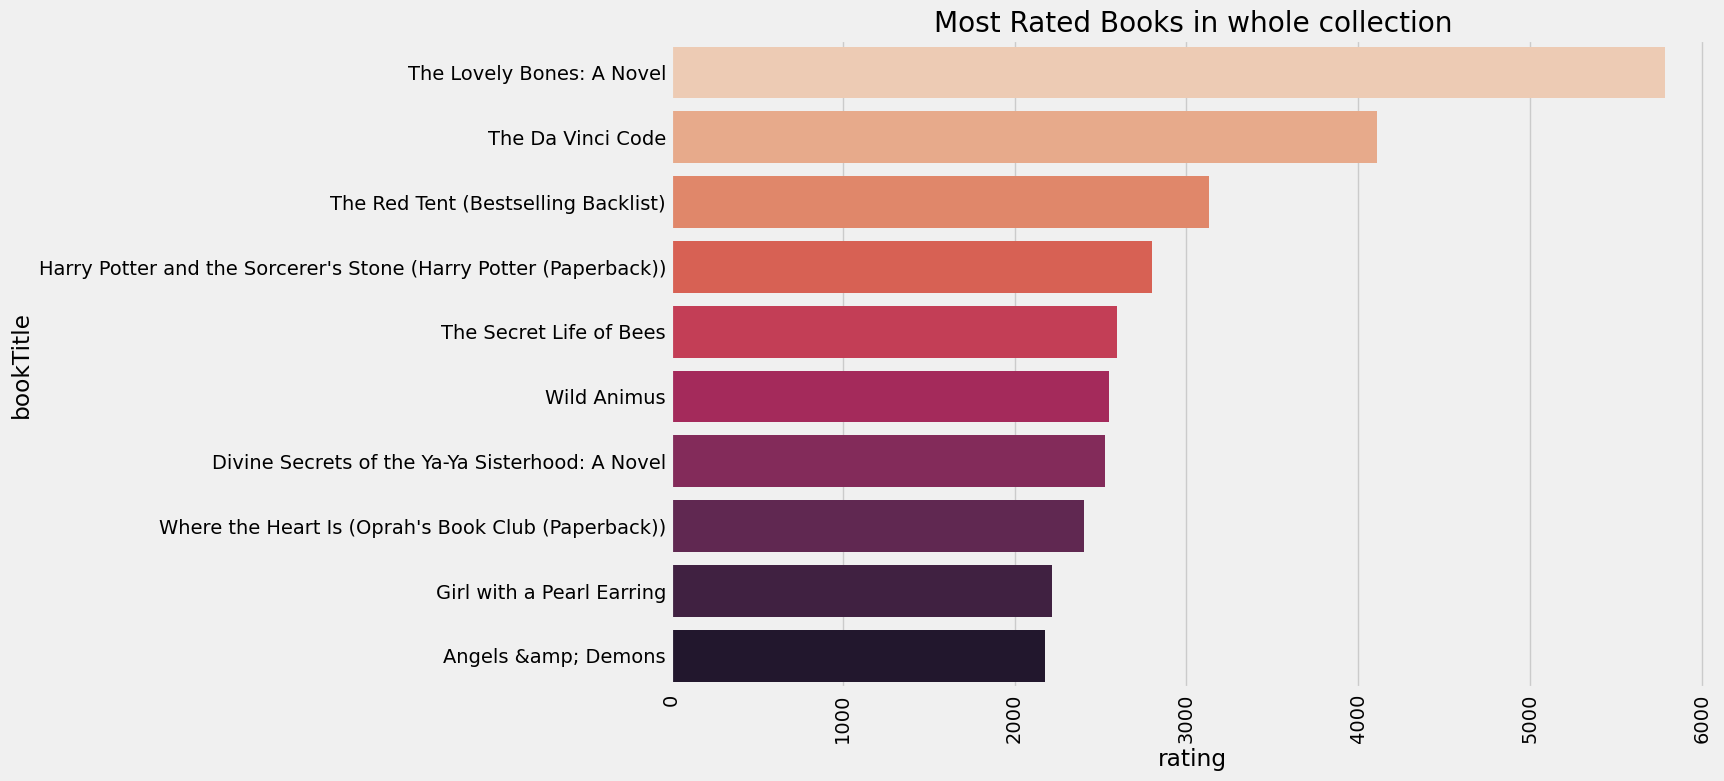

In [124]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in whole collection")

1. **The above chart shows the top 10 books in whole collection. We can recommend these books to the people who don't provide information about their age or country**
2. **"The Lovely Bones:A Novel" is the most popular book even though it is read by less number of people(around 500) as compared to "Wild Animus" which is read by around 1750 people. But "Wild Animus" is the 6th Popular book.**

### Q1 : Does popularity of books differ for different countries?

In [125]:
ratings_count_usa = pd.DataFrame(Final_dataset1_usa.groupby(['ISBN'])['rating'].sum())
top_10_usa = ratings_count_usa.sort_values('rating',ascending=False).head(10)
top_10_usa= top_10_usa.merge(book,left_index = True,right_on = 'ISBN')
top_10_usa

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,4356,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3327,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2473,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2410,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2296,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,2120,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,1847,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
118,1831,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
305,1758,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
231,1719,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in usa')

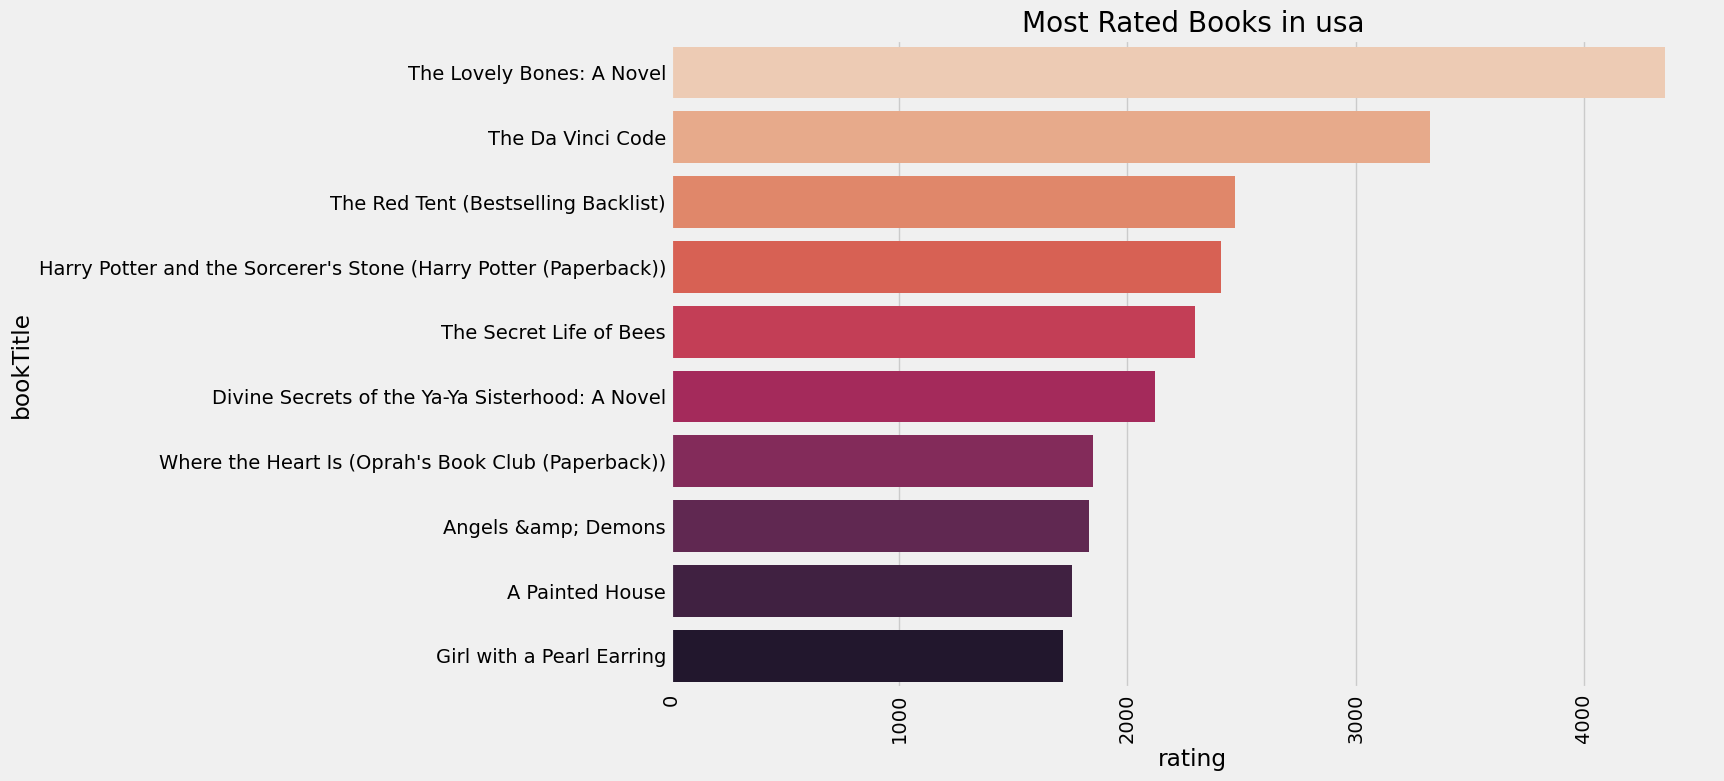

In [126]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_usa, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in usa")

1. **The above graph shows top 10 popular books in USA.**
2. **We have to observe one more fact that 9 out of 10 popular books of USA are same as popular books of whole collection.Because, USA contains about 60% of users in the whole dataset.**

In [127]:
ratings_count_uk = pd.DataFrame(Final_dataset1_uk.groupby(['ISBN'])['rating'].sum())
top_10_uk = ratings_count_uk.sort_values('rating',ascending=False).head(10)
top_10_uk = top_10_uk.merge(book,left_index = True,right_on = 'ISBN')
top_10_uk

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
3028,396,1844262553,Free,Paul Vincent,2003.0,Upfront Publishing,http://images.amazon.com/images/P/1844262553.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1844262553.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1844262553.01.LZZZZZZZ.jpg
166,322,0330332775,Bridget Jones's Diary,Helen Fielding,1997.0,Picador (UK),http://images.amazon.com/images/P/0330332775.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0330332775.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0330332775.01.LZZZZZZZ.jpg
1263,309,0099771519,Memoirs of a Geisha Uk,Arthur Golden,1996.0,Trafalgar Square,http://images.amazon.com/images/P/0099771519.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0099771519.01.LZZZZZZZ.jpg
5424,245,0552998486,Chocolat,Joanne Harris,2000.0,Black Swan,http://images.amazon.com/images/P/0552998486.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552998486.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552998486.01.LZZZZZZZ.jpg
1386,215,0590660543,Northern Lights (His Dark Materials S.),Philip Pullman,1998.0,Scholastic Point,http://images.amazon.com/images/P/0590660543.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590660543.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590660543.01.LZZZZZZZ.jpg
1381,213,0552996009,Notes From a Small Planet,Bill Bryson,1996.0,Bantam Doubleday Dell,http://images.amazon.com/images/P/0552996009.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552996009.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552996009.01.LZZZZZZZ.jpg
1261,196,000649840X,Angelas Ashes,Frank Mccourt,1996.0,Harpercollins Uk,http://images.amazon.com/images/P/000649840X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/000649840X.01.LZZZZZZZ.jpg
35059,185,0552999458,Dead Famous,Ben Elton,2002.0,"Black Swan Books, Limited",http://images.amazon.com/images/P/0552999458.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0552999458.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0552999458.01.LZZZZZZZ.jpg
810,165,0349101779,The Wasp Factory,Iain Banks,1996.0,Abacus,http://images.amazon.com/images/P/0349101779.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0349101779.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0349101779.01.LZZZZZZZ.jpg
6698,162,0007110928,Billy,Pamela Stephenson,2002.0,HarperCollins Entertainment,http://images.amazon.com/images/P/0007110928.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0007110928.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0007110928.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in uk')

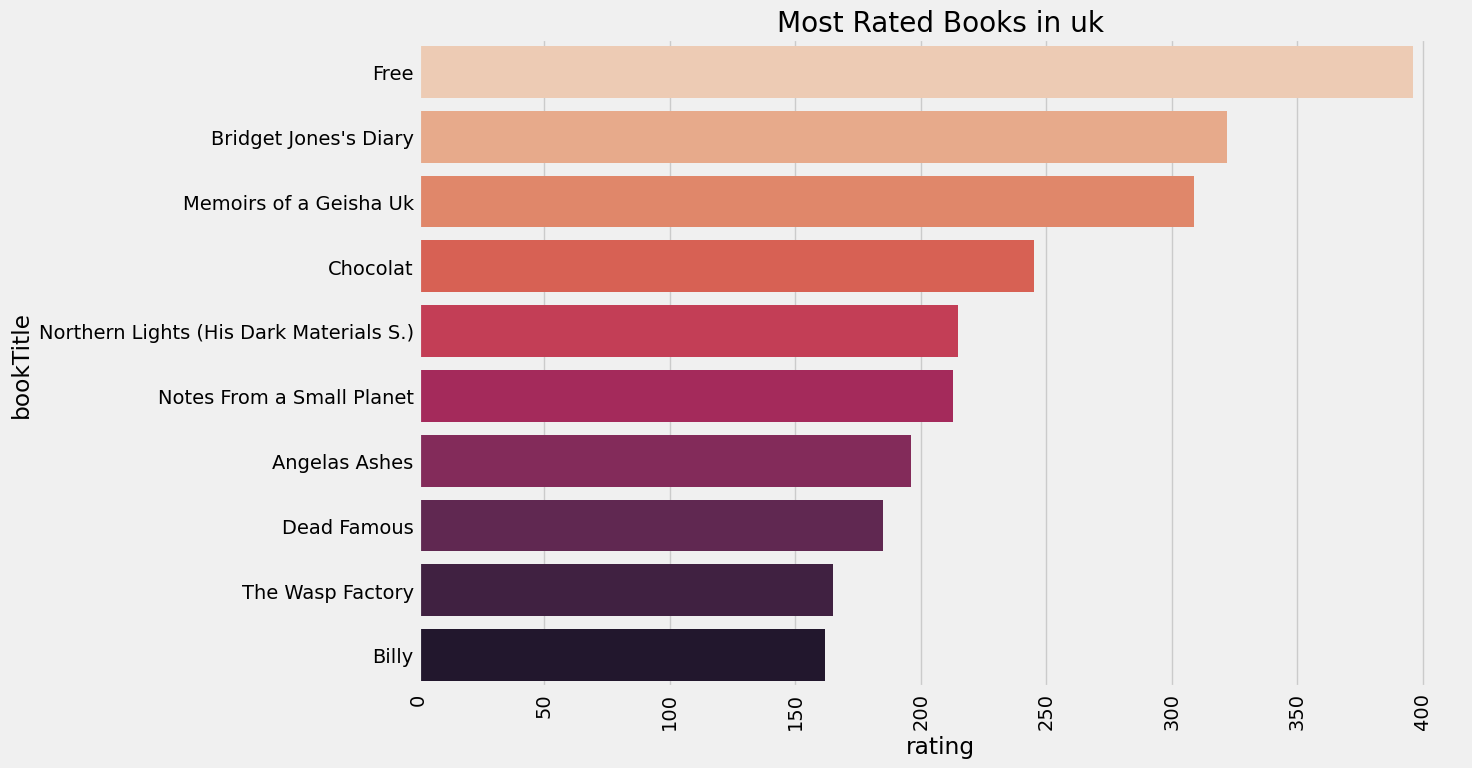

In [128]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_uk, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in uk")

1. **In UK, the most popular book is "Free".**
2. **We can see that Popular books of USA and UK differ from each other**

In [129]:
ratings_count_canada = pd.DataFrame(Final_dataset1_canada.groupby(['ISBN'])['rating'].sum())
top_10_canada = ratings_count_canada.sort_values('rating',ascending=False).head(10)
top_10_canada = top_10_canada.merge(book,left_index = True,right_on = 'ISBN')
top_10_canada

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,515,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
522,340,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
485,324,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998.0,Pocket,http://images.amazon.com/images/P/0671021001.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671021001.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671021001.01.LZZZZZZZ.jpg
67,319,0804106304,The Joy Luck Club,Amy Tan,1994.0,Prentice Hall (K-12),http://images.amazon.com/images/P/0804106304.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0804106304.01.LZZZZZZZ.jpg
5662,286,0440241073,The Summons,John Grisham,2002.0,Dell Publishing Company,http://images.amazon.com/images/P/0440241073.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.LZZZZZZZ.jpg
1922,280,067976402X,Snow Falling on Cedars,David Guterson,1995.0,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg
706,277,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
4578,273,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999.0,Scribner,http://images.amazon.com/images/P/0684872153.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0684872153.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0684872153.01.LZZZZZZZ.jpg
2445,259,0440214041,The Pelican Brief,John Grisham,1993.0,Dell,http://images.amazon.com/images/P/0440214041.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440214041.01.LZZZZZZZ.jpg
2526,244,0345337662,Interview with the Vampire,Anne Rice,1993.0,Ballantine Books,http://images.amazon.com/images/P/0345337662.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books in canada')

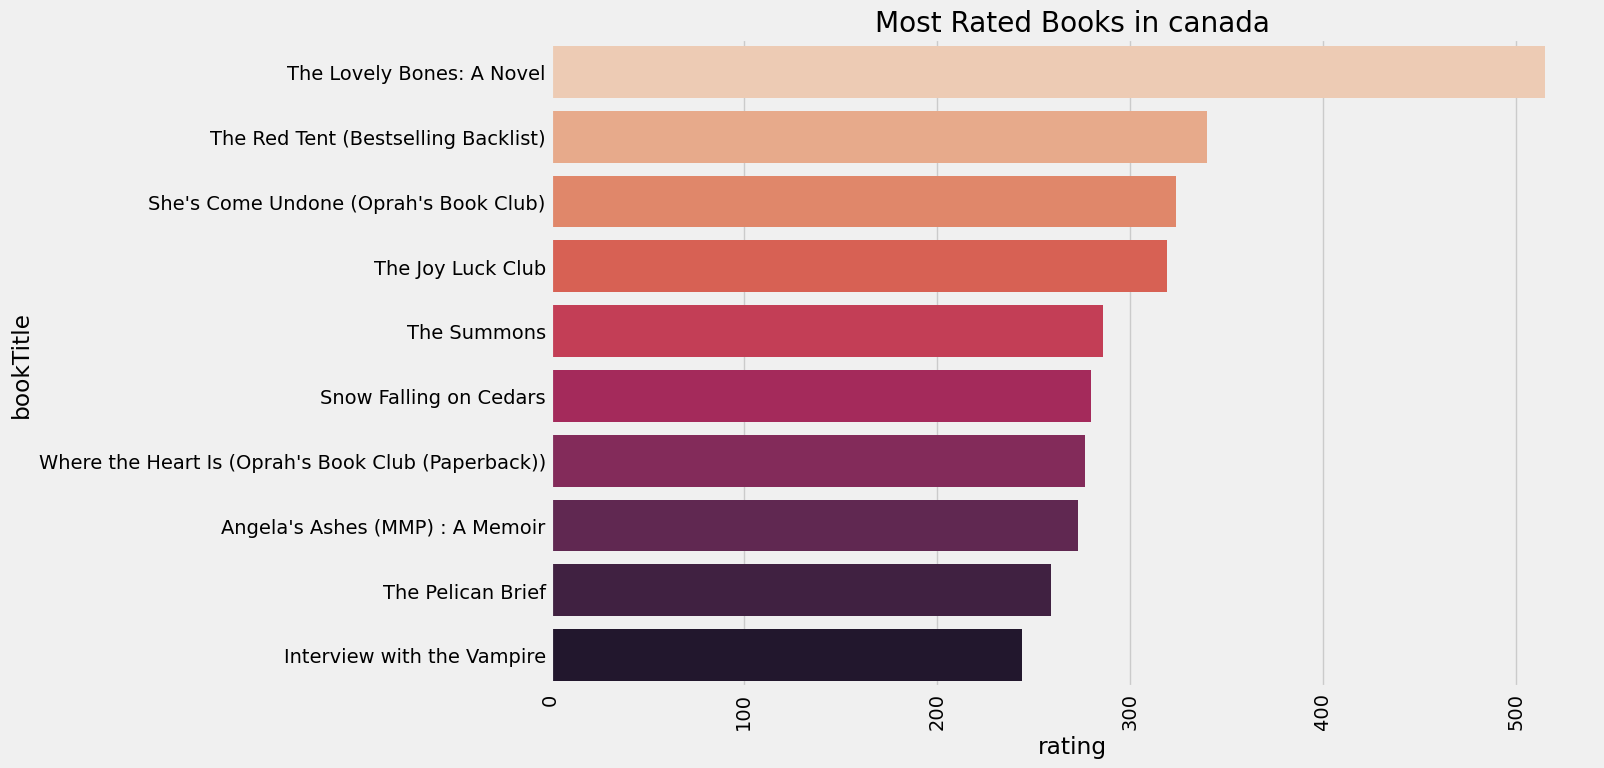

In [130]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_canada, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books in canada")

1. **Even in canada, Most popular book is The "The Lovely Bones : A Novel" is the most popular book.**
2. **The popular books of Canada, USA and UK are completely different even though USA and canada belong to the same continent**

#### So, Popularity differ from country to country. So we have to build different recommendation engine to different countries

### Q2. Does popularity differ for different age-groups?

In [131]:
ratings_count_kid = pd.DataFrame(Final_dataset1_kid.groupby(['ISBN'])['rating'].sum())
top_10_kid = ratings_count_kid.sort_values('rating',ascending=False).head(10)
top_10_kid = top_10_kid.merge(book,left_index = True,right_on = 'ISBN')
top_10_kid

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2143,64,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
800,48,0064407667,"The Bad Beginning (A Series of Unfortunate Events, Book 1)",Lemony Snicket,1999.0,HarperCollins,http://images.amazon.com/images/P/0064407667.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0064407667.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0064407667.01.LZZZZZZZ.jpg
3459,40,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000.0,Scholastic,http://images.amazon.com/images/P/0439064872.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439064872.01.LZZZZZZZ.jpg
36293,35,0440407524,Shiloh (Yearling Newbery),Phyllis Reynolds Naylor,1992.0,Yearling Books,http://images.amazon.com/images/P/0440407524.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440407524.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440407524.01.LZZZZZZZ.jpg
7956,32,059043411X,Vampires Don't Wear Polka Dots (Adventures of the Bailey School Kids (Paperback)),Debbie Dadey,1997.0,Scholastic,http://images.amazon.com/images/P/059043411X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059043411X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059043411X.01.LZZZZZZZ.jpg
1990,31,0590634275,Captain Underpants and the Attack of the Talking Toilets: Another Epic Novel (Captain Underpants...,Dav Pilkey,1999.0,Scholastic,http://images.amazon.com/images/P/0590634275.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0590634275.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0590634275.01.LZZZZZZZ.jpg
10306,30,0439049962,Captain Underpants and the Invasion of the Incredibly Naughty Cafeteria Ladies from Outer Space,Dav Pilkey,1999.0,Scholastic,http://images.amazon.com/images/P/0439049962.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439049962.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439049962.01.LZZZZZZZ.jpg
5649,29,0440414806,Holes (Yearling Newbery),LOUIS SACHAR,2000.0,Yearling,http://images.amazon.com/images/P/0440414806.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440414806.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440414806.01.LZZZZZZZ.jpg
3776,29,039480001X,The Cat in the Hat,Dr. Seuss,1957.0,Random House Books for Young Readers,http://images.amazon.com/images/P/039480001X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/039480001X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/039480001X.01.LZZZZZZZ.jpg
10495,29,0689859368,"The Field Guide (The Spiderwick Chronicles, Book 1)",Tony DiTerlizzi,2003.0,Simon &amp; Schuster Children's Publishing,http://images.amazon.com/images/P/0689859368.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0689859368.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0689859368.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among kids')

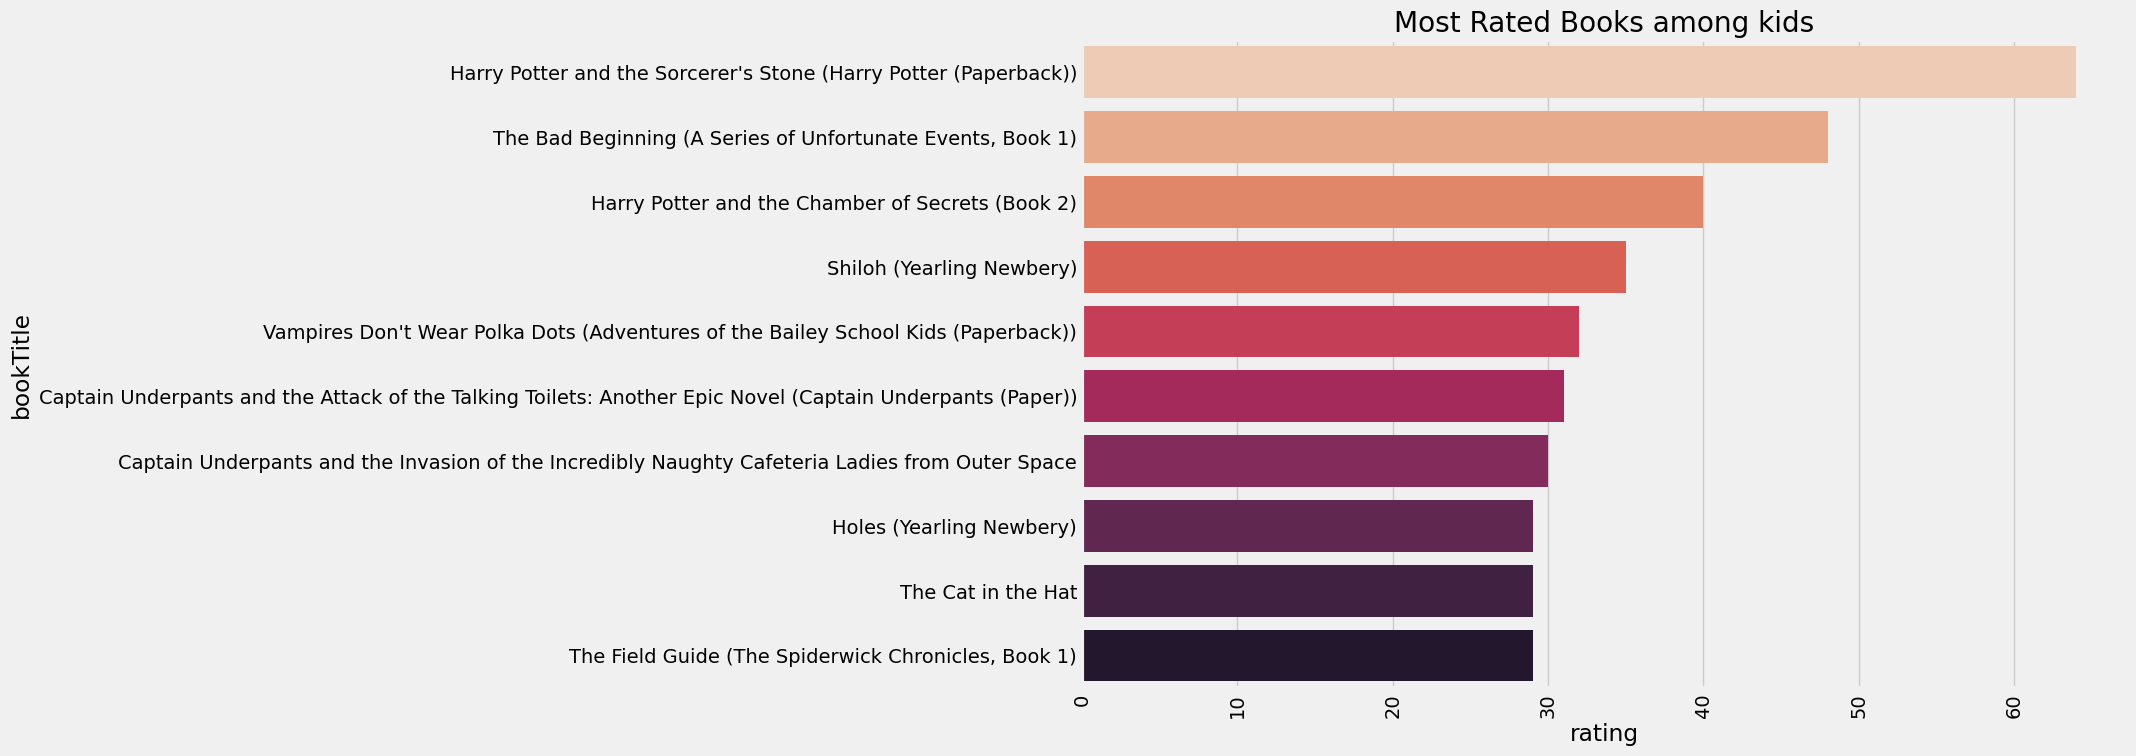

In [132]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_kid, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among kids")

1. **Harry Potter and Sorcerer's stone is the most popular book among kids**
2. **This list differs completely from the popular books from whole collection**

In [133]:
ratings_count_adult = pd.DataFrame(Final_dataset1_adult.groupby(['ISBN'])['rating'].sum())
top_10_adult = ratings_count_adult.sort_values('rating',ascending=False).head(10)
top_10_adult = top_10_adult.merge(book,left_index = True,right_on = 'ISBN')
top_10_adult

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5006,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3281,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2789,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2278,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
1105,2209,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
356,2178,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
706,2094,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,1889,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
26,1846,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
4824,1823,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999.0,Back Bay Books,http://images.amazon.com/images/P/0316601950.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among adults')

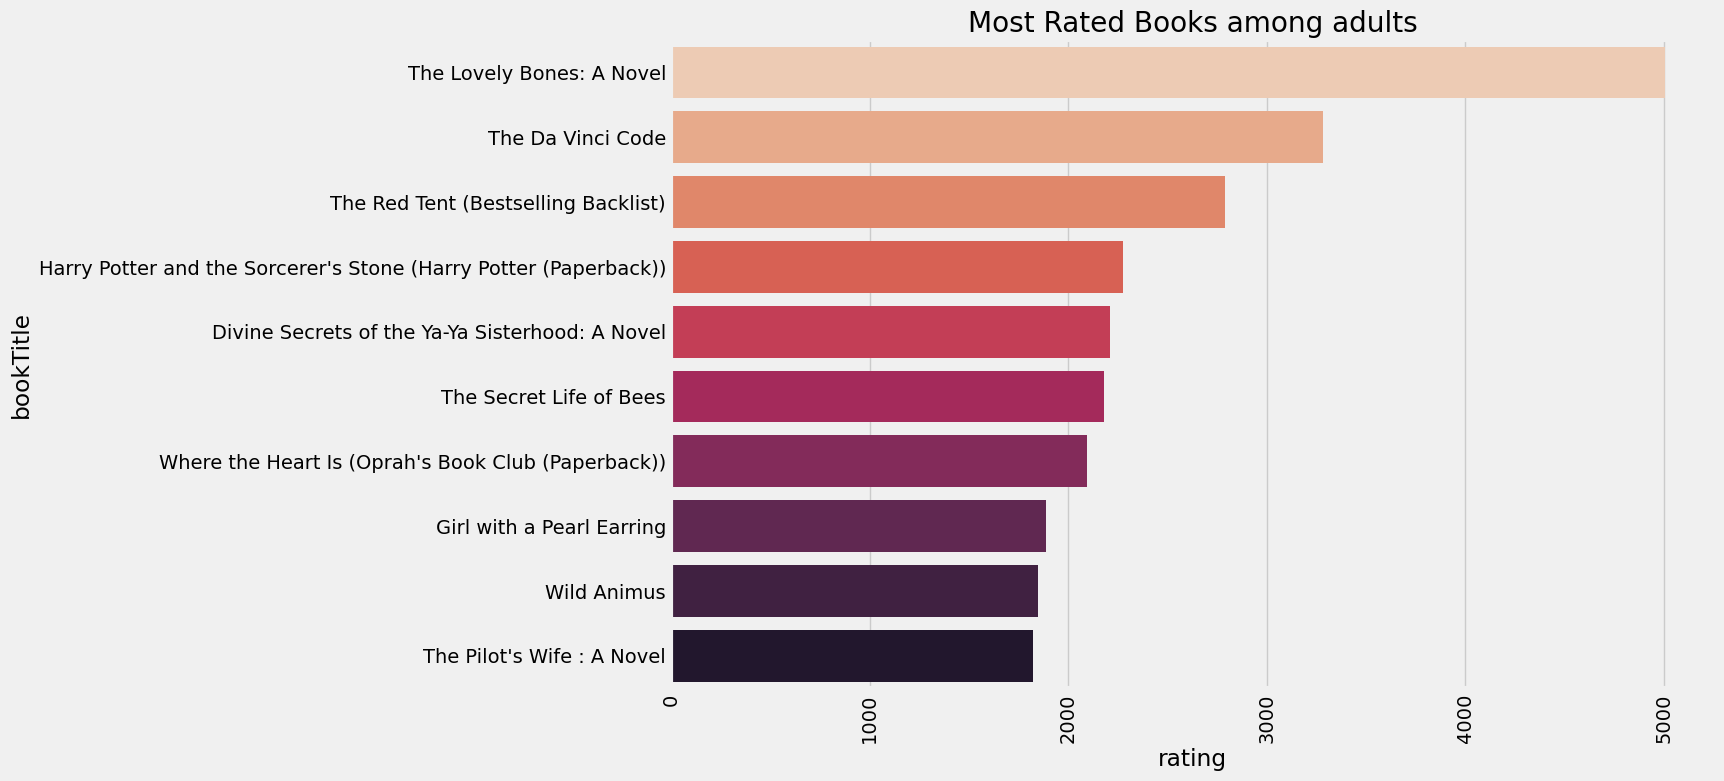

In [134]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_adult, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among adults")

1. **The Lovely Bones: A Novel is popular among adults**
2. **The 9 out of 10 popular books for adults is same as popular book for the whole collection. Because, Most number of users are adults in the whole dataset**

In [135]:
ratings_count_old = pd.DataFrame(Final_dataset1_old.groupby(['ISBN'])['rating'].sum())
top_10_old = ratings_count_old.sort_values('rating',ascending=False).head(10)
top_10_old = top_10_old.merge(book,left_index = True,right_on = 'ISBN')
top_10_old

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
748,764,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
408,535,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
26,402,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1406,388,1400034779,The No. 1 Ladies' Detective Agency (Today Show Book Club #8),Alexander McCall Smith,2003.0,Anchor,http://images.amazon.com/images/P/1400034779.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1400034779.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1400034779.01.LZZZZZZZ.jpg
107,360,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003.0,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
356,350,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
118,333,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
522,302,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
305,293,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
5662,281,0440241073,The Summons,John Grisham,2002.0,Dell Publishing Company,http://images.amazon.com/images/P/0440241073.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0440241073.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books among old people')

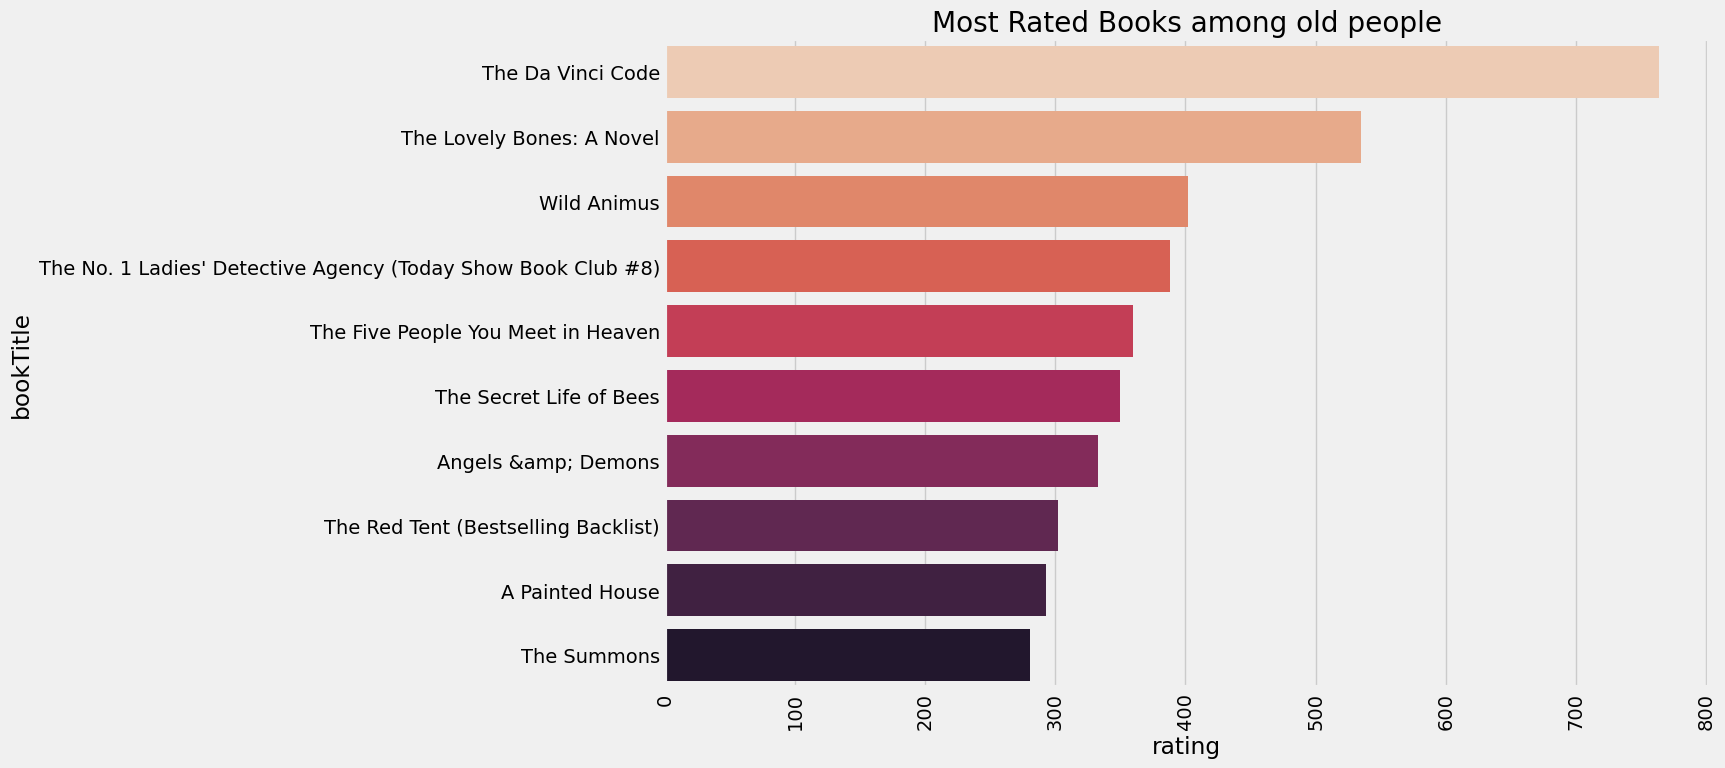

In [136]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_old, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books among old people")

1. **"The Da Vinci Code" is most popular book among old people.**
2. **6 out of 10 books are same for old people and the whole collection and 5 books match for adults and old people**

#### So, the Popular books differ according to age. So we have to build different reccomendation engines for different age groups

### Q3. Does popularity differ for different centuries of publication?

In [137]:
ratings_count_19 = pd.DataFrame(Final_dataset1_19.groupby(['ISBN'])['rating'].sum())
top_10_19 = ratings_count_19.sort_values('rating',ascending=False).head(10)
top_10_19 = top_10_19.merge(book,left_index = True,right_on = 'ISBN')
top_10_19

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
4824,2041,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999.0,Back Bay Books,http://images.amazon.com/images/P/0316601950.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.LZZZZZZZ.jpg
1922,1999,067976402X,Snow Falling on Cedars,David Guterson,1995.0,Vintage Books USA,http://images.amazon.com/images/P/067976402X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/067976402X.01.LZZZZZZZ.jpg
37,1914,0446310786,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446310786.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446310786.01.LZZZZZZZ.jpg
90,1868,0316769487,The Catcher in the Rye,J.D. Salinger,1991.0,"Little, Brown",http://images.amazon.com/images/P/0316769487.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316769487.01.LZZZZZZZ.jpg
2526,1789,0345337662,Interview with the Vampire,Anne Rice,1993.0,Ballantine Books,http://images.amazon.com/images/P/0345337662.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0345337662.01.LZZZZZZZ.jpg
1373,1783,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999.0,Perennial,http://images.amazon.com/images/P/0060930535.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060930535.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books which published in 19th century')

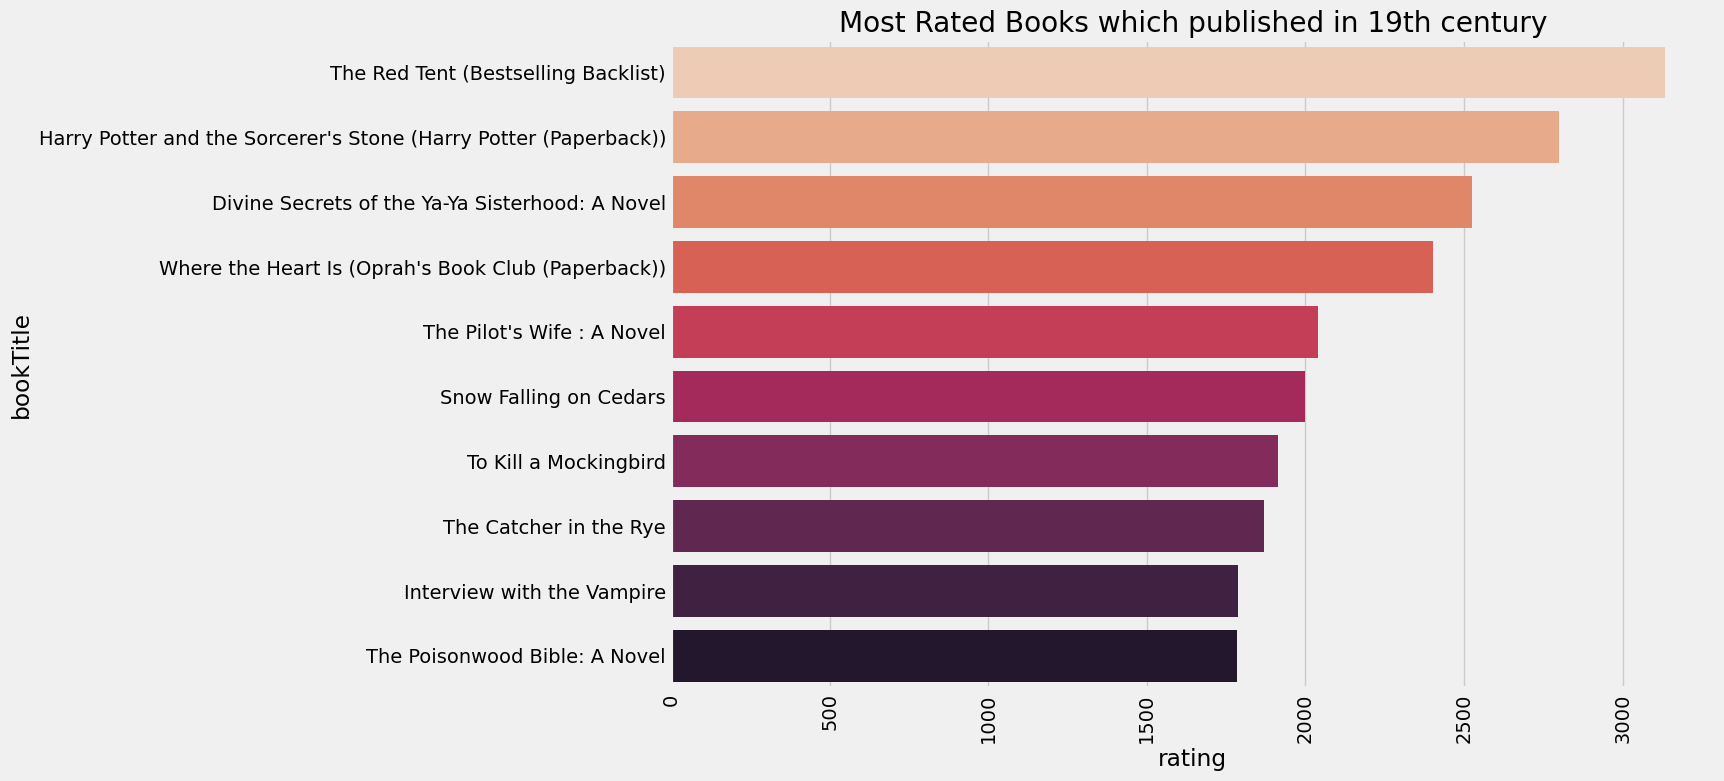

In [138]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_19, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books which published in 19th century")

**Among the books published in 19th century, "The Red Tent" is the most popular book**

In [139]:
ratings_count_20 = pd.DataFrame(Final_dataset1_20.groupby(['ISBN'])['rating'].sum())
top_10_20 = ratings_count_20.sort_values('rating',ascending=False).head(10)
top_10_20 = top_10_20.merge(book,left_index = True,right_on = 'ISBN')
top_10_20

,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2551,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
305,2062,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
107,1940,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003.0,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
1496,1899,0743418174,Good in Bed,Jennifer Weiner,2002.0,Washington Square Press,http://images.amazon.com/images/P/0743418174.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.LZZZZZZZ.jpg
5506,1861,043935806X,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003.0,Scholastic,http://images.amazon.com/images/P/043935806X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.LZZZZZZZ.jpg


Text(0.5, 1.0, 'Most Rated Books which published in 20h century')

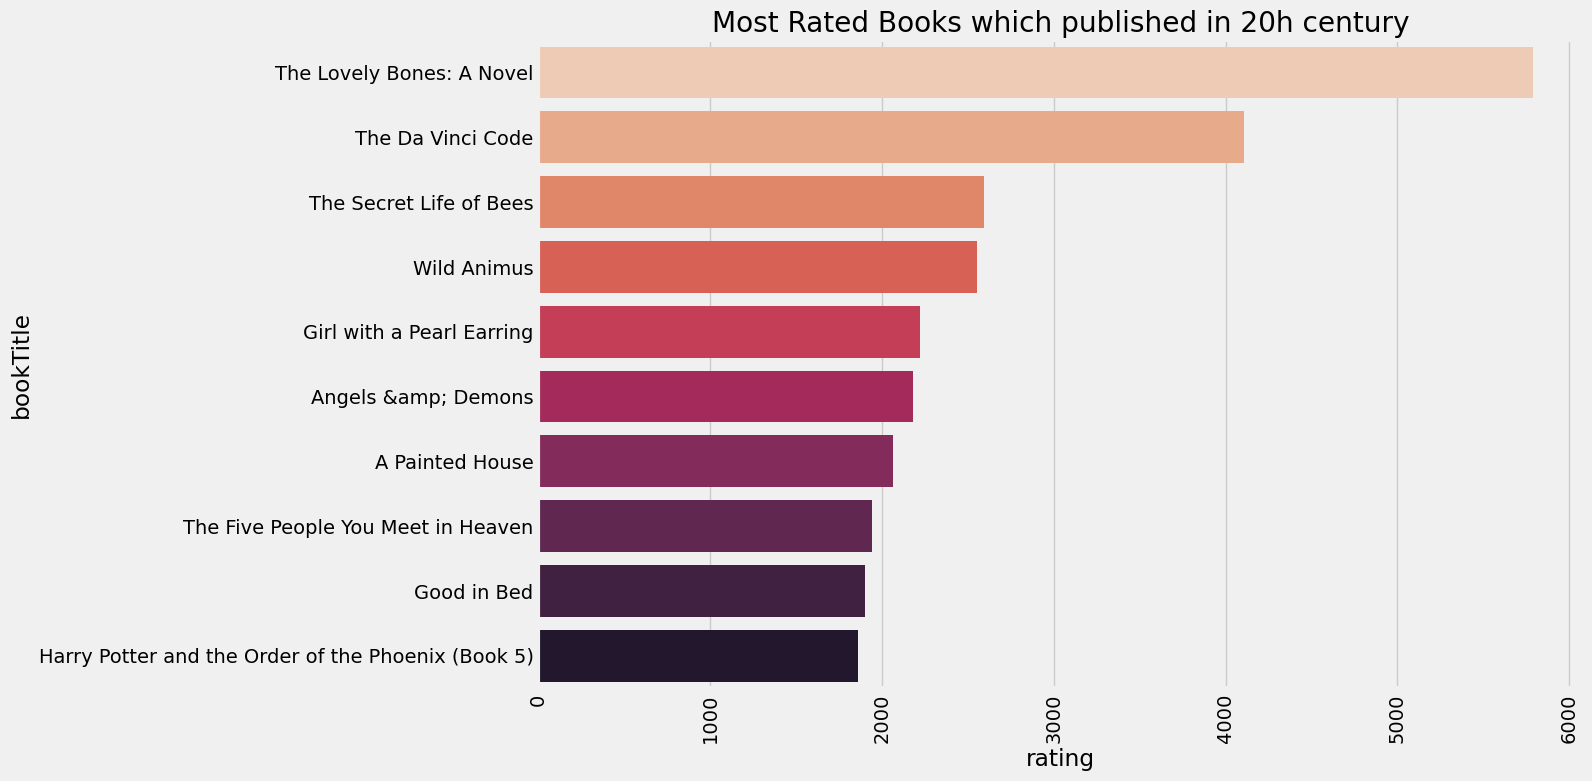

In [140]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_20, y='bookTitle', x = 'rating' ,palette='rocket_r')
plt.xticks(rotation=90)
plt.title("Most Rated Books which published in 20h century")

1. **The Lovely Bones : A Novel is the most popular book among the books published in the 20th century.**
2. **The 6 books out of 10 books in the popular books of whole collection are published in 20th century**

#### So, the Popular books can be found according to different centuries they have published.

#### From above graphs, we can say that "The Lovely Bones : The Novel" is most popular book among most of the age groups and countries

### Model Building

### 1.Top 10 books in whole collection

In [141]:
def popularity_based(dataframe):
    data = pd.DataFrame(dataframe.groupby(['ISBN'])['rating'].sum()).sort_values('rating',ascending=False).head(10)
    result = data.merge(book,left_index = True,right_on = 'ISBN')
    return result

In [142]:
print("Top 10 popular books in the whole collection are:")
popularity_based(Final_dataset1)

Top 10 popular books in the whole collection are:


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2551,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg


### 2. Top 10 books in a particular country

In [143]:
def Country_filter(dataframe,Country):
    Country = Country.lower()
    
    if Country in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == Country]
    else:
        return dataframe

In [144]:
Country = input("Enter your country name: ")
data = Country_filter(Final_dataset1,Country)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your country name: usa


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,4356,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3327,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2473,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2410,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,2296,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,2120,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,1847,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
118,1831,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
305,1758,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
231,1719,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg


### 3.Top 10 books for particular age group

In [145]:
def age_filter(dataframe,Age):
    if Age in range(0,13):
        return dataframe[dataframe['Age_group'] == 'kid']
    elif Age in range(13,20):
        return dataframe[dataframe['Age_group'] == 'Teenager']
    elif Age in range(20,51):
        return dataframe[dataframe['Age_group'] == 'Adult']
    elif Age in range(51,101):
        return dataframe[dataframe['Age_group'] == 'old']
    else:
        return dataframe

In [146]:
Age = int(input("Enter your age:"))
data = age_filter(Final_dataset1,Age)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your age:25


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5006,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,3281,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2789,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,2278,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
1105,2209,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
356,2178,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
706,2094,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
231,1889,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
26,1846,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
4824,1823,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999.0,Back Bay Books,http://images.amazon.com/images/P/0316601950.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316601950.01.LZZZZZZZ.jpg


### 4. Top 10 books of a particular publication century

In [147]:
def century_filter(dataframe,Publication_century):
    
    if Publication_century in list(dataframe['Publication_century'].unique()):
        return dataframe[dataframe['Publication_century'] == Publication_century]
    else:
        print("As we don't have the books from the publication century you asked,we reccommend you most popular books in our collection")
        return dataframe

In [148]:
Publication_century = int(input("Enter the publication century you want books from: "))
data = century_filter(Final_dataset1,Publication_century)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter the publication century you want books from: 20


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
26,2551,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0,Plume Books,http://images.amazon.com/images/P/0452282152.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0452282152.01.LZZZZZZZ.jpg
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
305,2062,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg
107,1940,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003.0,Hyperion,http://images.amazon.com/images/P/0786868716.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0786868716.01.LZZZZZZZ.jpg
1496,1899,0743418174,Good in Bed,Jennifer Weiner,2002.0,Washington Square Press,http://images.amazon.com/images/P/0743418174.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.LZZZZZZZ.jpg
5506,1861,043935806X,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003.0,Scholastic,http://images.amazon.com/images/P/043935806X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/043935806X.01.LZZZZZZZ.jpg


### 5. Top 10 books for a person of a particular age group and a perticular Country

In [149]:
def individual_filter(dataframe,Country,Age):
    Country = Country.lower()

    if (Country in list(dataframe['Country'].unique()) and Age in range(0,13)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'kid')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(13,20)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'Teenager')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(20,51)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'Adult')]
    elif (Country in list(dataframe['Country'].unique()) and Age in range(51,101)):
        return dataframe[(dataframe['Country'] == Country) & (dataframe['Age_group'] == 'old')]
    else:
        print("These are the popular books in our whole collection")
        return dataframe

In [150]:
Country = input("Enter your country name: ")
Age = int(input("Enter your age:"))

data = individual_filter(Final_dataset1,Country,Age)

if isinstance(data,pd.DataFrame):
    data = popularity_based(data)
data

Enter your country name: usa
Enter your age:25


,rating,ISBN,bookTitle,bookAuthor,publicationYear,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
408,3762,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
748,2579,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
522,2187,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg
2143,1976,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/059035342X.01.LZZZZZZZ.jpg
356,1914,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,http://images.amazon.com/images/P/0142001740.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0142001740.01.LZZZZZZZ.jpg
1105,1867,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
706,1591,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998.0,Warner Books,http://images.amazon.com/images/P/0446672211.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446672211.01.LZZZZZZZ.jpg
118,1524,0671027360,Angels &amp; Demons,Dan Brown,2001.0,Pocket Star,http://images.amazon.com/images/P/0671027360.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0671027360.01.LZZZZZZZ.jpg
1496,1514,0743418174,Good in Bed,Jennifer Weiner,2002.0,Washington Square Press,http://images.amazon.com/images/P/0743418174.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0743418174.01.LZZZZZZZ.jpg
305,1496,044023722X,A Painted House,John Grisham,2001.0,Dell Publishing Company,http://images.amazon.com/images/P/044023722X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/044023722X.01.LZZZZZZZ.jpg


## Collaborative filtering

In [151]:
new_df = dataset[['userId','ISBN','bookTitle','rating']]
new_df

,userId,ISBN,bookTitle,rating
0,2,0195153448,Classical Mythology,0
1,8,0002005018,Clara Callan,5
2,11400,0002005018,Clara Callan,0
3,11676,0002005018,Clara Callan,8
4,41385,0002005018,Clara Callan,0
...,...,...,...,...
1031127,278851,0743203763,As Hogan Said . . . : The 389 Best Things Anyone Said about How to Play Golf,0
1031128,278851,0767907566,All Elevations Unknown: An Adventure in the Heart of Borneo,5
1031129,278851,0884159221,Why stop?: A guide to Texas historical roadside markers,7
1031130,278851,0912333022,The Are You Being Served? Stories: 'Camping In' and Other Fiascoes,7


In [152]:
len(new_df.userId.unique())

92106

In [153]:
len(new_df.bookTitle.unique())

241068

In [154]:
new_df['userId'].value_counts()

userId
11676     11144
198711     6456
153662     5814
98391      5777
35859      5646
          ...  
68986         1
41015         1
52228         1
177481        1
278729        1
Name: count, Length: 92106, dtype: int64

In [155]:
new_df=new_df[new_df['userId'].map(new_df['userId'].value_counts()) > 200]

In [156]:
new_df['userId'].value_counts()

userId
11676     11144
198711     6456
153662     5814
98391      5777
35859      5646
          ...  
201783      201
164323      201
269890      201
246311      201
178199      201
Name: count, Length: 811, dtype: int64

In [157]:
new_df.shape

(474004, 4)

In [158]:
new_df['Total_No_Of_Users_Rated']=new_df.groupby('ISBN')['rating'].transform('count')
new_df['Total_No_Of_Users_Rated'].unique()

array([  4,   3,  10,   1,   2, 121,  51,   7, 330,  60,  98,  38,   6,
        25,  22,  12,   5, 136,  62,  17,  16,  11,  73,  46,  72,  61,
        33,  43, 130,   8,  24, 169,   9,  64,  63,  45,  21,  83,  84,
        77,  80,  41, 108,  91, 165,  31,  65,  42,  20, 141,  32,  75,
        39,  30,  15,  29,  13,  81,  58, 109, 167, 261,  36, 110,  26,
       153,  68,  40,  59, 114,  48,  50, 155, 158,  34,  37,  71,  76,
        18,  78,  19, 115,  47,  14,  70,  88,  79,  57,  87,  23,  49,
        92,  28,  53, 105, 104,  66,  67, 102, 103,  54, 164,  44,  56,
       123, 188,  89,  27,  74, 142, 128, 197,  95,  94, 132, 122,  55,
        99, 118,  35, 106, 125, 178,  52, 207, 201, 135,  90, 217, 162,
       152, 113,  86,  69, 134, 159, 180,  96,  82, 177, 111, 211, 140,
        93,  85, 124, 100, 131, 117], dtype=int64)

In [159]:
new_df=new_df[new_df['Total_No_Of_Users_Rated']>50]
new_df

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
101,2977,0440234743,The Testament,0,121
103,3363,0440234743,The Testament,0,121
106,7346,0440234743,The Testament,9,121
112,11676,0440234743,The Testament,9,121
115,13552,0440234743,The Testament,8,121
...,...,...,...,...,...
494926,252071,0312971125,Crazy for You,0,62
494928,258185,0312971125,Crazy for You,0,62
494929,263877,0312971125,Crazy for You,0,62
494930,265115,0312971125,Crazy for You,10,62


In [160]:
new_df["bookTitle"] = new_df["bookTitle"].astype('str')

In [161]:
users_pivot=new_df.pivot_table(index=["userId"],columns=["bookTitle"],values="rating")

In [162]:
users_pivot.fillna(0,inplace = True)
users_pivot

bookTitle,1st to Die: A Novel,2nd Chance,4 Blondes,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Fine Balance,A Great Deliverance,A Heartbreaking Work of Staggering Genius,...,Wicked: The Life and Times of the Wicked Witch of the West,Wifey,Wild Animus,Wish You Well,Without Remorse,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
userId,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
users_pivot.loc[182085]

bookTitle
1st to Die: A Novel                                                  0.0
2nd Chance                                                           0.0
4 Blondes                                                            0.0
A Bend in the Road                                                   0.0
A Case of Need                                                       0.0
                                                                    ... 
Year of Wonders                                                      0.0
You Belong To Me                                                     0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values    0.0
Zoya                                                                 0.0
\O\" Is for Outlaw"                                                  0.0
Name: 182085, Length: 475, dtype: float64

In [164]:
similarity=cosine_similarity(users_pivot)
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [165]:
def users_choice(id):
    
    users_fav=new_df[new_df["userId"]==id].sort_values(["rating"],ascending=False)[0:5]
    return users_fav

* **Using the below function(user_bsed), we found similarity between the users by cosine similarity function. Then we have sorted the users using their similarity values in the descending order**.
* **Then we have choosen the userIds which are most similar to the given user Id**

In [166]:
def user_based(new_df,id):
    index=np.where(users_pivot.index==id)[0][0]
    similarity=cosine_similarity(users_pivot)
    similar_users=list(enumerate(similarity[index]))
    similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[1:6]

    user_rec=[]

    for i in similar_users:
            data=new_df[new_df["userId"]==users_pivot.index[i[0]]]
            user_rec.extend(list(data.drop_duplicates("userId")["userId"].values))
    return user_rec

* **Then we have formed the dataframe of similar user ids. Then we removed the rows in which books read by the given user was there.**
* **Then we have sorted the books in the descending order of their rating**

In [167]:
def common(new_df,user,user_id):
    x=new_df[new_df["userId"]==user_id]
    recommend_books=[]
    reco_rating=[]
    user=list(user)
    for i in user:
        y=new_df[(new_df["userId"]==i)]
        books=y.loc[~y["bookTitle"].isin(x["bookTitle"]),:]
        books=books.sort_values(["rating"],ascending=False)[0:1]
        recommend_books.extend(books["bookTitle"].values)
        recommend_books.extend(books["rating"].values)

    return recommend_books

In [168]:
user_id=int(input("Enter the userid: "))
#user_id=random.choice(new_df["userId"].values)
user_choice_df=pd.DataFrame(users_choice(user_id))
user_favorite=users_choice(user_id)
n=len(user_choice_df["bookTitle"].values)
print("🟦 USER: {} ".format(user_id))

Enter the userid: 11500
🟦 USER: 11500 


In [169]:
def similar_users(user_id):
    user_index = np.where(users_pivot.index==user_id)[0][0]
    distances = similarity[user_index]
    user_list = sorted(list(enumerate(distances)),reverse = True,key = lambda x:x[1])[1:11]
    
    for i in user_list:
        print(users_pivot.index[i[0]])

In [170]:
similar_users(11676)

16795
104636
95359
153662
43246
7346
258534
60244
35859
21014


In [171]:
print("=====Fav Books=====".title())

for i in range(n):
        books=new_df.loc[new_df["bookTitle"]==user_choice_df["bookTitle"].tolist()[i],"bookTitle"][:1].values[0]
        print(books , ("-- RATING: {} ".format(round(new_df[new_df["bookTitle"]==user_choice_df["bookTitle"].tolist()[i]]["rating"].mean(),1))))

=====Fav Books=====


In [172]:
user_id=int(input("Enter the userid: "))
if user_id in new_df["userId"].values:
    user_based_rec=user_based(new_df,user_id)
    books_for_user=common(new_df,user_based_rec,user_id)
    books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
    print("=====Recommended books=====".title())
    rec_books = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::2].values, 'rating':books_for_userDF['bookTitle'].iloc[1::2].values})
    print(rec_books)
elif user_id in dataset["userId"].values:
    Country = dataset.loc[dataset.userId == user_id, 'Country'].values[0]
    Country=Country.upper()
    Age = dataset.loc[dataset.userId == user_id, 'Age'].values[0]
    data = individual_filter(Final_dataset1,Country,Age)
    data = popularity_based(data)
    print(data['bookTitle'])
else:
    rec =popularity_based(Final_dataset1)
    print(rec['bookTitle'])

Enter the userid: 125
408                                            The Lovely Bones: A Novel
748                                                    The Da Vinci Code
522                                  The Red Tent (Bestselling Backlist)
2143    Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
356                                              The Secret Life of Bees
1105                     Divine Secrets of the Ya-Ya Sisterhood: A Novel
706                   Where the Heart Is (Oprah's Book Club (Paperback))
118                                                  Angels &amp; Demons
1496                                                         Good in Bed
305                                                      A Painted House
Name: bookTitle, dtype: object


In [173]:
new_df[(new_df["userId"]==180348)&(new_df["bookTitle"]=="Wild Animus")]['rating']

Series([], Name: rating, dtype: int64)

In [174]:
new_df[new_df["bookTitle"]=="Wild Animus"]

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
788,2766,0971880107,Wild Animus,6,330
790,2977,0971880107,Wild Animus,0,330
792,3363,0971880107,Wild Animus,0,330
813,6251,0971880107,Wild Animus,0,330
816,6543,0971880107,Wild Animus,0,330
...,...,...,...,...,...
3210,271195,0971880107,Wild Animus,0,330
3213,271448,0971880107,Wild Animus,2,330
3235,273979,0971880107,Wild Animus,0,330
3241,274301,0971880107,Wild Animus,0,330


In [175]:
#For userId 11676
user_id=int(input("Enter the userid: "))
if user_id not in new_df["userId"].values:
    rec =popularity_based(Final_dataset1)
    print(rec['bookTitle'])
else:    
    user_based_rec=user_based(new_df,user_id)
    books_for_user=common(new_df,user_based_rec,user_id)
    books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
    print("=====Recommended books=====".title())
    rec_books = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::2].values, 'rating':books_for_userDF['bookTitle'].iloc[1::2].values})
    print(rec_books)

Enter the userid: 11676
=====Recommended Books=====
                                  recm_books rating
0                          Girl, Interrupted      9
1                  Pretend You Don't See Her      9
2    The Gunslinger (The Dark Tower, Book 1)      8
3  A Thin Dark Line (Mysteries &amp; Horror)     10
4          Seven Up (A Stephanie Plum Novel)      5


In [176]:
#For userId 78553
user_id=int(input("Enter the userid: "))
if user_id not in new_df["userId"].values:
    rec =popularity_based(Final_dataset1)
    print(rec['bookTitle'])
else:    
    user_based_rec=user_based(new_df,user_id)
    books_for_user=common(new_df,user_based_rec,user_id)
    books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
    print("=====Recommended books=====".title())
    rec_books = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::2].values, 'rating':books_for_userDF['bookTitle'].iloc[1::2].values})
    print(rec_books)

Enter the userid: 78533
408                                            The Lovely Bones: A Novel
748                                                    The Da Vinci Code
522                                  The Red Tent (Bestselling Backlist)
2143    Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
356                                              The Secret Life of Bees
26                                                           Wild Animus
1105                     Divine Secrets of the Ya-Ya Sisterhood: A Novel
706                   Where the Heart Is (Oprah's Book Club (Paperback))
231                                            Girl with a Pearl Earring
118                                                  Angels &amp; Demons
Name: bookTitle, dtype: object


In [177]:
#For userId 76499
user_id=int(input("Enter the userid: "))
if user_id not in new_df["userId"].values:
    rec =popularity_based(Final_dataset1)
    print(rec['bookTitle'])
else:    
    user_based_rec=user_based(new_df,user_id)
    books_for_user=common(new_df,user_based_rec,user_id)
    books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
    print("=====Recommended books=====".title())
    rec_books = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::2].values, 'rating':books_for_userDF['bookTitle'].iloc[1::2].values})
    print(rec_books)

Enter the userid: 76499
=====Recommended Books=====
                                                                 recm_books  \
0  Stupid White Men ...and Other Sorry Excuses for the State of the Nation!   
1                                                               The Summons   
2                                            Seabiscuit: An American Legend   
3                                                     It's Always Something   
4                                                 Dude, Where's My Country?   

  rating  
0      9  
1     10  
2     10  
3     10  
4     10  


In [178]:
#For userId 98391
user_id=int(input("Enter the userid: "))
if user_id not in new_df["userId"].values:
    rec =popularity_based(Final_dataset1)
    print(rec['bookTitle'])
else:    
    user_based_rec=user_based(new_df,user_id)
    books_for_user=common(new_df,user_based_rec,user_id)
    books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
    print("=====Recommended books=====".title())
    rec_books = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::2].values, 'rating':books_for_userDF['bookTitle'].iloc[1::2].values})
    print(rec_books)

Enter the userid: 98931
408                                            The Lovely Bones: A Novel
748                                                    The Da Vinci Code
522                                  The Red Tent (Bestselling Backlist)
2143    Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
356                                              The Secret Life of Bees
26                                                           Wild Animus
1105                     Divine Secrets of the Ya-Ya Sisterhood: A Novel
706                   Where the Heart Is (Oprah's Book Club (Paperback))
231                                            Girl with a Pearl Earring
118                                                  Angels &amp; Demons
Name: bookTitle, dtype: object


## Evaluation

* **In the evaluation part, we have taken 5 random users, we haven't removed the books which are read by the given user Id and sorted the books in the descending order of their rating and recommended 10 most rated books.**
* **And we have checked the rating of each book by the given user Id.**
* **We found that all the 10 books by the random users fall in the range of >5 rating by the given user.**
* **So we can say that our engine is working efficiently**

In [179]:
def common_ev(new_df,user,user_id):
    x=new_df[new_df["userId"]==user_id]
    recommend_books=[]
    reco_rating=[]
    user=list(user)
    for i in user:
        y=new_df[(new_df["userId"]==i)]
#         books=y.loc[~y["bookTitle"].isin(x["bookTitle"]),:]
        books=y.sort_values(["rating"],ascending=False)[0:2]
        recommend_books.extend(books["bookTitle"].values)
        recommend_books.extend(books["rating"].values)

    return recommend_books

In [181]:
#For userId 31556
user_id=int(input("Enter the userid: "))
user_based_rec=user_based(new_df,user_id)
books_for_user=common_ev(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
print("=====Recommended books=====".title())

rec_books1 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::4].values, 'rating':books_for_userDF['bookTitle'].iloc[2::4].values})
rec_books2 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[1::4].values, 'rating':books_for_userDF['bookTitle'].iloc[3::4].values})
rec_books=rec_books1._append(rec_books2)
print(rec_books)

Enter the userid: 31556
=====Recommended Books=====
                                                         recm_books rating
0                                             To Kill a Mockingbird      9
1    Anne of Green Gables (Anne of Green Gables Novels (Paperback))     10
2                                             To Kill a Mockingbird     10
3            The Return of the King (The Lord of the Rings, Part 3)     10
4                      Harry Potter and the Goblet of Fire (Book 4)     10
0      The Hobbit : The Enchanting Prelude to The Lord of the Rings      9
1  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))     10
2                  Harry Potter and the Chamber of Secrets (Book 2)      8
3      The Hobbit : The Enchanting Prelude to The Lord of the Rings     10
4                 Harry Potter and the Prisoner of Azkaban (Book 3)     10


In [182]:
specf_id_1 =new_df[(new_df["userId"]==31556)]
specf_id_1

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
141,31556,0440234743,The Testament,0,121
4266,31556,0446310786,To Kill a Mockingbird,10,136
5009,31556,0671888587,I'll Be Seeing You,0,73
7783,31556,0316769487,The Catcher in the Rye,5,83
10826,31556,0671042858,The Girl Who Loved Tom Gordon,0,65
...,...,...,...,...,...
339326,31556,0553213172,Anne of the Island,0,53
374381,31556,0425109720,Patriot Games (Jack Ryan Novels),0,61
379117,31556,0515124214,Inner Harbor (Quinn Brothers (Paperback)),0,58
438202,31556,0446603589,Absolute Power,0,59


In [183]:
#For userId 11676
user_id=int(input("Enter the userid: "))
user_based_rec=user_based(new_df,user_id)
books_for_user=common_ev(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
print("=====Recommended books=====".title())

rec_books1 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::4].values, 'rating':books_for_userDF['bookTitle'].iloc[2::4].values})
rec_books2 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[1::4].values, 'rating':books_for_userDF['bookTitle'].iloc[3::4].values})
rec_books=rec_books1._append(rec_books2)
print(rec_books)

Enter the userid: 11676
=====Recommended Books=====
                                                                 recm_books  \
0                                                   The Secret Life of Bees   
1                                                                   Secrets   
2                                     The Sweet Potato Queens' Book of Love   
3                                   Midnight in the Garden of Good and Evil   
4                 Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback))   
0                                                        That Camden Summer   
1                                                                  The Firm   
2  Stupid White Men ...and Other Sorry Excuses for the State of the Nation!   
3                                                            Fahrenheit 451   
4                                                                  Chocolat   

  rating  
0     10  
1     10  
2     10  
3     10  
4     10  
0     10  
1

In [184]:
specf_id_2 =new_df[(new_df["userId"]==11676)]
specf_id_2

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
112,11676,0440234743,The Testament,9,121
530,11676,0452264464,Beloved (Plume Contemporary Fiction),8,51
853,11676,0971880107,Wild Animus,6,330
3275,11676,0345402871,Airframe,0,60
3492,11676,0345417623,Timeline,10,98
...,...,...,...,...,...
440503,11676,0449223604,M Is for Malice,5,69
441884,11676,0451197747,The Deep End of the Ocean,8,58
444908,11676,051511992X,That Camden Summer,8,64
447601,11676,0553278029,A Great Deliverance,8,51


In [185]:
#For userId 78553
user_id=int(input("Enter the userid: "))
user_based_rec=user_based(new_df,user_id)
books_for_user=common_ev(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
print("=====Recommended books=====".title())

rec_books1 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::4].values, 'rating':books_for_userDF['bookTitle'].iloc[2::4].values})
rec_books2 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[1::4].values, 'rating':books_for_userDF['bookTitle'].iloc[3::4].values})
rec_books=rec_books1._append(rec_books2)
print(rec_books)

Enter the userid: 78553
=====Recommended Books=====
                                           recm_books rating
0    Harry Potter and the Chamber of Secrets (Book 2)     10
1    Harry Potter and the Chamber of Secrets (Book 2)     10
2               Anne Frank: The Diary of a Young Girl     10
3       Fried Green Tomatoes at the Whistle Stop Cafe      9
4        Harry Potter and the Goblet of Fire (Book 4)     10
0   Harry Potter and the Prisoner of Azkaban (Book 3)     10
1   Harry Potter and the Prisoner of Azkaban (Book 3)     10
2   Harry Potter and the Prisoner of Azkaban (Book 3)     10
3    Harry Potter and the Chamber of Secrets (Book 2)      9
4  Harry Potter and the Order of the Phoenix (Book 5)     10


In [186]:
specf_id_3 =new_df[(new_df["userId"]==78553)]
specf_id_3

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
1470,78553,0971880107,Wild Animus,0,330
6628,78553,0804106304,The Joy Luck Club,0,169
23562,78553,0515130389,Carolina Moon,10,78
25791,78553,1558744150,Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper)),0,68
32124,78553,0439064864,Harry Potter and the Chamber of Secrets (Book 2),10,60
32652,78553,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),10,66
33071,78553,0439139597,Harry Potter and the Goblet of Fire (Book 4),10,67
33298,78553,043935806X,Harry Potter and the Order of the Phoenix (Book 5),10,102
35573,78553,0451167317,The Dark Half,0,58
36446,78553,051512317X,Rising Tides,0,56


In [187]:
#For userId 76499
user_id=int(input("Enter the userid: "))
user_based_rec=user_based(new_df,user_id)
books_for_user=common_ev(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
print("=====Recommended books=====".title())

rec_books1 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::4].values, 'rating':books_for_userDF['bookTitle'].iloc[2::4].values})
rec_books2 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[1::4].values, 'rating':books_for_userDF['bookTitle'].iloc[3::4].values})
rec_books=rec_books1._append(rec_books2)
print(rec_books)

Enter the userid: 76499
=====Recommended Books=====
                                                                 recm_books  \
0  Stupid White Men ...and Other Sorry Excuses for the State of the Nation!   
1                                                                   Contact   
2                                            Seabiscuit: An American Legend   
3                                     Anne Frank: The Diary of a Young Girl   
4                                     Anne Frank: The Diary of a Young Girl   
0                                                                   Contact   
1                                                               The Summons   
2                                                   A Prayer for Owen Meany   
3                                                     It's Always Something   
4                                                 Dude, Where's My Country?   

  rating  
0      9  
1     10  
2     10  
3     10  
4     10  
0      8  
1

In [188]:
specf_id_4 =new_df[(new_df["userId"]==76499)]
specf_id_4

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
38080,76499,0671021001,She's Come Undone (Oprah's Book Club),5,123
56717,76499,014029628X,Girl in Hyacinth Blue,10,73
91682,76499,0553296981,Anne Frank: The Diary of a Young Girl,10,62
173460,76499,0671004107,Contact,10,53
174031,76499,0060921145,Animal Dreams,5,56
241815,76499,0440414806,Holes (Yearling Newbery),10,54


In [189]:
#For userId 98391
user_id=int(input("Enter the userid: "))
user_based_rec=user_based(new_df,user_id)
books_for_user=common_ev(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["bookTitle"])
print("=====Recommended books=====".title())

rec_books1 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[::4].values, 'rating':books_for_userDF['bookTitle'].iloc[2::4].values})
rec_books2 = pd.DataFrame({'recm_books':books_for_userDF['bookTitle'].iloc[1::4].values, 'rating':books_for_userDF['bookTitle'].iloc[3::4].values})
rec_books=rec_books1._append(rec_books2)
print(rec_books)

Enter the userid: 98391
=====Recommended Books=====
                                   recm_books rating
0                      Truly, Madly Manhattan      8
1  Key of Knowledge (Key Trilogy (Paperback))     10
2                             Purity in Death     10
3                   The Lovely Bones: A Novel     10
4                             Purity in Death     10
0                          Engaging The Enemy      7
1      Key of Light (Key Trilogy (Paperback))     10
2                           The Pelican Brief     10
3                             Deception Point      9
4                           J Is for Judgment     10


In [190]:
specf_id_5 =new_df[(new_df["userId"]==98391)]
specf_id_5

,userId,ISBN,bookTitle,rating,Total_No_Of_Users_Rated
5536,98391,042518630X,Purity in Death,9,61
9249,98391,0786868716,The Five People You Meet in Heaven,10,108
15439,98391,0316666343,The Lovely Bones: A Novel,9,261
28638,98391,0312305060,The Hours: A Novel,8,88
36646,98391,051513287X,Face the Fire (Three Sisters Island Trilogy),9,98
59699,98391,0553583441,Touching Evil,9,58
65869,98391,0385504209,The Da Vinci Code,10,207
88739,98391,067101420X,"Forever... : A Novel of Good and Evil, Love and Hope",9,54
140269,98391,051513628X,Key of Light (Key Trilogy (Paperback)),10,68
140406,98391,0515136379,Key of Knowledge (Key Trilogy (Paperback)),10,62


In [191]:
import pickle

In [192]:
pickle.dump(users_pivot, open('users_pivot.pkl','wb'))
pickle.dump(new_df, open('new_df.pkl','wb'))

In [193]:
!pip install streamlit